

---



# CITS4012 Natural Language Processing
## Project 2, Semester 1 2022



> **Akhil Naseem (22237476)**\
**Ankit Kamboj (23372936)**

---





In [ ]:
import torch
import torch.nn as nn
 
loss = nn.CrossEntropyLoss()
logits = torch.tensor([[3.0,4.0,1.0],[5,2,3],[2,1,6],[1,1,5]]) #manual values
y_true = torch.tensor([1,0,2,0]) #manual values
loss(logits, y_true)


tensor(1.1449)

In [ ]:
import torch
import torch.nn as nn
 
loss = nn.NLLLoss()
log_softmax = nn.LogSoftmax(dim=1)

logits = torch.tensor([[3,4,1],[5,2,3],[2,1,6],[1,1,5]]).float() #manual values
y_true = torch.tensor([1,0,2,2]) #manual values

activations = log_softmax(logits)
print(activations.exp())
loss(activations, y_true)


tensor([[0.2595, 0.7054, 0.0351],
        [0.8438, 0.0420, 0.1142],
        [0.0179, 0.0066, 0.9756],
        [0.0177, 0.0177, 0.9647]])


tensor(0.1449)

# 1.&nbsp; Data Exploration




## 1.1&nbsp; Imports

In [ ]:
# Google Colab has gensim 3.x by default, so need to upgrade
%pip install --upgrade gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 24.1 MB 12.2 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [ ]:
# imports
from argparse import Namespace
from bokeh.io import push_notebook, output_notebook
from bokeh.models import ColumnDataSource, LabelSet
from bokeh.plotting import figure, show
from collections import Counter
from gensim.corpora import Dictionary
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
from google.colab import drive
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from torch.nn import functional as F
from torch.utils.data import Dataset
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
import collections
import gensim
import gensim.downloader as api
import json
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import pandas as pd
import re
import string
import torch
import torch.nn as nn
import torch.optim as optim

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1.2&nbsp; Load data and pre-process

In [ ]:
sheet_url = 'https://docs.google.com/spreadsheets/d/1gtMo1Aky51hkI21ByBn0Lnd_vgAhhou58fLo5eSgvPM/edit#gid=1617069648'
url_1 = sheet_url.replace('/edit#gid=', '/export?format=csv&gid=')
complete_Data = pd.read_csv(url_1)
complete_Data = complete_Data.dropna()
complete_Data.head()

,category,job_type,job_description
0,Retail & Consumer Products,Full Time,Have you had 10 years experience in fresh pro...
1,Government & Defence,Full Time,The Opportunity: The Client Solution Analyst ...
2,Trades & Services,Full Time,An innovative business development role for a...
3,Trades & Services,Full Time,About the role: We are seeking an Automotive W...
4,Trades & Services,Full Time,Â Early starts and weekend shifts. No experien...


In [ ]:
# subset data to 2000 records only
data = complete_Data.iloc[0:2000,]
data = data.reset_index(drop=True)

# remove non alpanumerical characters
data['job_description'] = (data['job_description']
                                      .str.replace('â€™', "'")
                                      .str.replace('Â', '')
                                      .str.replace(r'[^\x00-\x7F]', ' ')
)

# replace 'Part Time', 'Contract', 'Vacation/Casual', all to 'Other'
data['job_type'] = np.where((data.job_type != 'Full Time'), 'Other', data.job_type)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  if __name__ == '__main__':


In [ ]:
# preprocess job_description column and tokenize
docs = data['job_description'].apply(gensim.utils.simple_preprocess)

# Create Bag of Words dictionary where key:value is word:count
document=[]
for row in docs:
    document = document + row
dictionary = Dictionary()
BoW_corpus = dictionary.doc2bow(document, allow_update=True)
BoW_corpus_dict = {dictionary[id]: freq for id, freq in BoW_corpus}

## 1.3&nbsp; Train domain specific word embeddings

In [ ]:
# cores = 2
# domain_wv = Word2Vec(min_count=1,
#                  window=2,
#                  vector_size=100,
#                  sample=6e-5, 
#                  alpha=0.03, 
#                  min_alpha=0.0007, 
#                  negative=20)

In [ ]:
# from time import time

# t = time()

# domain_wv.build_vocab(docs)

# print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

In [ ]:
# domain_wv.corpus_count

In [ ]:
# t = time()

# domain_wv.train(docs, total_examples=domain_wv.corpus_count, epochs=50)

# print('Time to train the embeddings: {} mins'.format(round((time() - t) / 60, 2)))

In [ ]:
# domain_wv.wv.save_word2vec_format('/content/drive/MyDrive/CITS4012/domain_embeddings.txt', binary=False)

## 1.4&nbsp; Load Glove word embeddings

In [ ]:
# glove_wv = api.load('glove-wiki-gigaword-50')
# glove_wv.save('/content/drive/MyDrive/CITS4012/pretrained_models/glove-wiki-gigaword-50')

In [ ]:
# glove_wv = KeyedVectors.load('/content/drive/MyDrive/CITS4012/pretrained_models/word2vec-google-news-300')
glove_wv = KeyedVectors.load('/content/drive/MyDrive/CITS4012/pretrained_models/glove-wiki-gigaword-50')

In [ ]:
domain_wv = Word2Vec.load('/content/drive/MyDrive/CITS4012/domain_embeddings.bin')
domain_wv.wv.key_to_index.keys()

dict_keys(['and', 'to', 'the', 'of', 'in', 'for', 'with', 'you', 'will', 'be', 'is', 'experience', 'are', 'our', 'we', 'this', 'on', 'work', 'an', 'team', 'your', 'role', 'as', 'have', 'or', 'skills', 'business', 'that', 'management', 'apply', 'working', 'please', 'all', 'ability', 'at', 'service', 'support', 'position', 'opportunity', 'customer', 'about', 'within', 'environment', 'their', 'services', 'strong', 'people', 'company', 'development', 'if', 'new', 'from', 'time', 'high', 'including', 'successful', 'australia', 'looking', 'who', 'by', 'must', 'excellent', 'client', 'required', 'join', 'part', 'communication', 'project', 'provide', 'career', 'well', 'not', 'training', 'sales', 'across', 'manager', 'industry', 'ensure', 'now', 'it', 'clients', 'key', 'based', 'opportunities', 'what', 'knowledge', 'years', 'health', 'highly', 'professional', 'staff', 'full', 'current', 'care', 'quality', 'more', 'great', 'au', 'experienced', 'level', 'has', 'com', 'can', 'information', 'other',

## 1.5&nbsp; Visualise and compare the two embeddings

### 1.5.1&nbsp;TSNE drawing functions

In [ ]:
def interactive_tsne(title, text_labels, tsne_array):
    '''makes an interactive scatter plot with text labels for each point'''

    # Define a dataframe to be used by bokeh context
    bokeh_df = pd.DataFrame(tsne_array, text_labels, columns=['x','y'])
    bokeh_df['text_labels'] = bokeh_df.index

    # interactive controls to include to the plot
    TOOLS="hover, zoom_in, zoom_out, box_zoom, undo, redo, reset, box_select"

    p = figure(title=title, tools=TOOLS, plot_width=700, plot_height=700)

    # define data source for the plot
    source = ColumnDataSource(bokeh_df)

    # scatter plot
    p.scatter('x', 'y', source=source, fill_alpha=0.6,
              fill_color="#8724B5",
              line_color=None)

    # text labels
    labels = LabelSet(x='x', y='y', text='text_labels', y_offset=8,
                      text_font_size="8pt", text_color="#555555",
                      source=source, text_align='center')

    p.add_layout(labels)

    # show plot inline
    output_notebook()
    show(p)

In [ ]:
def display_interactive_tsne(title, word2vec_emb):
    vocab_sorted = dict(sorted(BoW_corpus_dict.items(), key=lambda item: item[1], reverse=True))
    input_vocab =  [word for word in vocab_sorted if word in word2vec_emb.key_to_index.keys() and word not in stopwords.words('english')]
    points = 25
    X = word2vec_emb[input_vocab]
    tsne = TSNE(n_components=2, random_state=0)
    X_tsne = tsne.fit_transform(X[:points])

    interactive_tsne(title, list(input_vocab)[:points], X_tsne)

In [ ]:
def display_closestwords_tsnescatterplot(model_name, model, word):
    
    arr = np.empty((0,model.vector_size), dtype='f')
    word_labels = [word]

    # get close words
    close_words = model.similar_by_word(word)
    
    # add the vector for each of the closest words to the array
    arr = np.append(arr, np.array([model[word]]), axis=0)
    for wrd_score in close_words:
        wrd_vector = model[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
        
    # find tsne coords for 2 dimensions
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    # display scatter plot
    plt.scatter(x_coords, y_coords)

    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
    plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.title(f'{model_name} - words closest to: {word}')
    plt.show()

### 1.5.2&nbsp; Glove vs Domain embeddings

In [ ]:
# words similar to 'engineer' according to pre-trained glove embeddings
glove_wv.most_similar(positive=["engineer"])

[('mechanic', 0.7610689997673035),
 ('technician', 0.7588814496994019),
 ('engineers', 0.7152684926986694),
 ('worked', 0.7083118557929993),
 ('pioneer', 0.7055997848510742),
 ('retired', 0.6979386806488037),
 ('chemist', 0.6946015954017639),
 ('engineering', 0.6913756132125854),
 ('contractor', 0.686898410320282),
 ('builder', 0.6847971081733704)]

In [ ]:
# words similar to 'engineer' according to domain specific embeddings
domain_wv.wv.most_similar(positive=["engineer"])

[('developer', 0.5319417119026184),
 ('drafter', 0.5085623264312744),
 ('architect', 0.48913365602493286),
 ('technician', 0.4842866361141205),
 ('warwick', 0.45811372995376587),
 ('engineers', 0.4476262032985687),
 ('designer', 0.4407448470592499),
 ('surveyor', 0.43743979930877686),
 ('analyst', 0.4319444000720978),
 ('administrator', 0.41785332560539246)]

In [ ]:
display_interactive_tsne("GLOVE WORD2VEC - 50 points", glove_wv)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [ ]:
display_interactive_tsne("DOMAIN SPECIFIC WORD2VEC - 50 points", domain_wv.wv)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


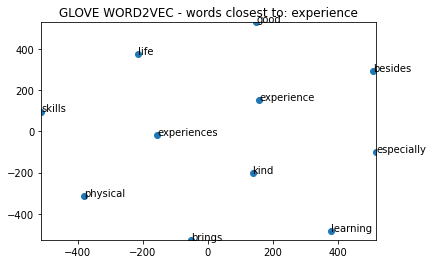

In [ ]:
display_closestwords_tsnescatterplot("GLOVE WORD2VEC", glove_wv, "experience")

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


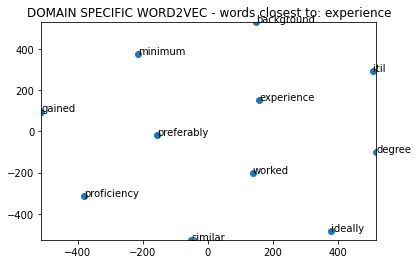

In [ ]:
display_closestwords_tsnescatterplot("DOMAIN SPECIFIC WORD2VEC", domain_wv.wv, "experience")

## 1.6&nbsp; Create embedding matrix from embedding file

Here we define functions to create embeddings matrices to pass into our classifier models for training.

Words that are not in either embeddings' vocabulary will be added to to vocab as '\<UNK>' during vectorization, whose vector will be uniform Glorot/Xavier[1] initialised.

[1] _Understanding the difficulty of training deep feedforward neural networks_ - Glorot, X. & Bengio, Y. (2010)

In [ ]:
def load_embedding_from_file(embedding_filepath): 
    word_to_index = {}
    embeddings = []
    with open(embedding_filepath, encoding="utf8") as fp:
        for index, line in enumerate(fp):
            line = line.split(" ") # each line: word num1 num2 ...
            word_to_index[line[0]] = index # word = line[0] 
            embedding_i = np.array([float(val) for val in line[1:]])
            embeddings.append(embedding_i)
    return word_to_index, np.stack(embeddings)

def make_embedding_matrix(embedding_filepath, words):
    word_to_idx, embeddings = load_embedding_from_file(embedding_filepath)
    embedding_size = embeddings.shape[1]
    
    final_embeddings = np.zeros((len(words), embedding_size))

    for i, word in enumerate(words):
        if word in word_to_idx:
            final_embeddings[i, :] = embeddings[word_to_idx[word]]
        else:
            embedding_i = torch.ones(1, embedding_size)
            torch.nn.init.xavier_uniform_(embedding_i)
            final_embeddings[i, :] = embedding_i
    return final_embeddings

# 2.&nbsp; Data Preprocessing and Preparation

## 2.1&nbsp;Use TDIDF to create top10words column

In [ ]:
data['top10words'] = np.nan
data_groupedby_cat = data.groupby(['category'])

In [ ]:
tvec = TfidfVectorizer(stop_words='english')

def top10wordsbycat(category, topn):
    tvec_weights = tvec.fit_transform(data_groupedby_cat.get_group(category).job_description)
    dict_of_tokens={i[1]:i[0] for i in tvec.vocabulary_.items()}
    tfidf_vectors = []
    for row in tvec_weights:
        tfidf_vectors.append({dict_of_tokens[column]:value for (column,value) in zip(row.indices, row.data)})
    
    doc_sorted_tfidfs=[]  # list of doc features each with tfidf weight

    #sort each dict of a document
    for dn in tfidf_vectors:
        sorted_doc = sorted(dn.items(), key=lambda x: x[1], reverse=True)
        doc_sorted_tfidfs.append(sorted_doc[0:topn])
    
    
    for row_i, topwords_tfidfs in zip(data_groupedby_cat.get_group(category).index, doc_sorted_tfidfs):
        data['top10words'][row_i] = [word for word, weight in topwords_tfidfs]

In [ ]:
np.warnings.filterwarnings('ignore')
for name, group in data_groupedby_cat:
    top10wordsbycat(name, 10)

In [ ]:
data

,category,job_type,job_description,top10words
0,Retail & Consumer Products,Full Time,Have you had 10 years experience in fresh pro...,"[food, fresh, produce, 10, good, manage, teams..."
1,Government & Defence,Full Time,The Opportunity: The Client Solution Analyst ...,"[desirable, desk, powerlink, solution, resolut..."
2,Trades & Services,Full Time,An innovative business development role for a...,"[laundry, orange, adelaide, sky, van, focus, w..."
3,Trades & Services,Full Time,About the role: We are seeking an Automotive W...,"[cvs, unsolicited, mechanical, line, members, ..."
4,Trades & Services,Full Time,Early starts and weekend shifts. No experienc...,"[teach, early, great, apprenticeship, weekend,..."
...,...,...,...,...
1995,Information & Communication Technology,Other,"Our client, a large multi-national corporatio...","[service, incidents, customer, smec, hundreds,..."
1996,Legal,Full Time,Are you looking for a step up into a PA / EA p...,"[events, assisting, expect, powerpoint, regula..."
1997,Hospitality & Tourism,Full Time,Restaurant Managers for a rapidly growing Int...,"[rolld, collaborative, business, managers, fam..."
1998,Marketing & Communications,Full Time,About the business WedShed is a platform brin...,"[bringing, business, like, weddings, good, got..."


## 2.2&nbsp;Split dataset into train, val, test
train: 70%
val: 20%
test:10%

In [ ]:
args = Namespace(
    raw_train_dataset_csv="/content/drive/MyDrive/CITS4012/raw_train.csv",
    raw_test_dataset_csv="/content/drive/MyDrive/CITS4012/raw_test.csv",
    train_proportion=0.7,
    test_proportion=0.2,
    val_proportion=0.1,
    output_munged_csv="/content/drive/MyDrive/CITS4012/job_type_with_splits_full.csv",
    output_munged_csv2="/content/drive/MyDrive/CITS4012/job_type_with_category_full.csv",
    seed=1337
)

In [ ]:
by_jobtype = collections.defaultdict(list)
for _, row in data.iterrows():
    by_jobtype[row.job_type].append(row.to_dict())

In [ ]:
final_list = []
np.random.seed(args.seed)

for _, item_list in sorted(by_jobtype.items()):

    np.random.shuffle(item_list)
    
    n_total = len(item_list)
    n_train = int(args.train_proportion * n_total)
    n_val = int(args.val_proportion * n_total)
    n_test = int(args.test_proportion * n_total)
    
    # Give data point a split attribute
    for item in item_list[:n_train]:
        item['split'] = 'train'
    
    for item in item_list[n_train:n_train+n_val]:
        item['split'] = 'val'

    for item in item_list[n_train+n_val:n_train+n_val+n_test+1]:
        item['split'] = 'test'

    # Add to final list
    final_list.extend(item_list)

In [ ]:
final_data = pd.DataFrame(final_list)
final_data['top_10_words']=final_data['top10words']

In [ ]:
final_data.split.value_counts()

train    1399
test      401
val       199
Name: split, dtype: int64

In [ ]:
final_data

,category,job_type,job_description,top10words,split,top_10_words
0,Information & Communication Technology,Full Time,We are an award winning and trusted brand for...,"[mssql, javascript, helpdesk, attention, abili...",train,"[mssql, javascript, helpdesk, attention, abili..."
1,Banking & Financial Services,Full Time,Equity Market Strategist - CommSec Do work th...,"[commsec, media, markets, customers, market, e...",train,"[commsec, media, markets, customers, market, e..."
2,"Farming, Animals & Conservation",Full Time,2 Year Full Time Fixed Term Contract 7 da...,"[farm, nature, working, parks, position, exper...",train,"[farm, nature, working, parks, position, exper..."
3,Banking & Financial Services,Full Time,Join a team you'll love within a company Austr...,"[mortgage, broker, brokers, aussie, perfect, e...",train,"[mortgage, broker, brokers, aussie, perfect, e..."
4,Education & Training,Full Time,This well established and large global childc...,"[managers, role, operations, overall, regional...",train,"[managers, role, operations, overall, regional..."
...,...,...,...,...,...,...
1995,Healthcare & Medical,Other,Position Title: Senior Technical / Scientific...,"[st, vincent, upload, neurophysiology, health,...",test,"[st, vincent, upload, neurophysiology, health,..."
1996,Information & Communication Technology,Other,We are currently recruiting for an experienced...,"[mapping, documenting, challenge, previous, en...",test,"[mapping, documenting, challenge, previous, en..."
1997,"Manufacturing, Transport & Logistics",Other,Process Workers South Gippsland Rapidly g...,"[dairy, viplus, gbs, production, gippsland, pr...",test,"[dairy, viplus, gbs, production, gippsland, pr..."
1998,"Manufacturing, Transport & Logistics",Other,Company Our client is a recognised national p...,"[lo, warehousing, reach, high, solutions, oper...",test,"[lo, warehousing, reach, high, solutions, oper..."


In [ ]:
job_type_data=final_data[["job_type","job_description","top10words","split"]].copy()

In [ ]:
job_type_data.to_csv(args.output_munged_csv, index=False)

In [ ]:
job_category_data=final_data[["category","job_description",'top_10_words',"split"]].copy()

In [ ]:
job_category_data.to_csv(args.output_munged_csv2, index=False)

# 3.&nbsp; Reusable helper functions

## 3.1&nbsp; General utilities

In [ ]:
# General utilities
def set_seed_everywhere(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)

def handle_dirs(dirpath):
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)

## 3.2&nbsp; Model initialisation function

In [ ]:
def modelInitialisation(args):
    if args.expand_filepaths_to_save_dir:
        args.vectorizer_file = os.path.join(args.save_dir,
                                            args.vectorizer_file)

        args.model_state_file = os.path.join(args.save_dir,
                                            args.model_state_file)
        
        print("Expanded filepaths: ")
        print("\t{}".format(args.vectorizer_file))
        print("\t{}".format(args.model_state_file))
    
    # Check CUDA
    if not torch.cuda.is_available():
        args.cuda = False
        
    args.device = torch.device("cuda" if args.cuda else "cpu")
    print("Using CUDA: {}".format(args.cuda))

    # Set seed for reproducibility
    set_seed_everywhere(args.seed, args.cuda)

    # handle dirs
    handle_dirs(args.save_dir)

    # Initializations
    if args.reload_from_files:
    # load dataset and vectorizer
        dataset = args.dataset.load_dataset_and_load_vectorizer(args.data_csv, args.vectorizer_file)
    else:
        # create dataset and vectorizer
        dataset = args.dataset.load_dataset_and_make_vectorizer(args.data_csv)
        dataset.save_vectorizer(args.vectorizer_file)
    vectorizer = dataset.get_vectorizer()

    # Use pretrained GloVe, domain_embeddings or one hot embeddings
    if args.use_glove:
        words = vectorizer.top_10_words_vocab._token_to_idx.keys()
        embeddings = make_embedding_matrix(embedding_filepath=args.glove_filepath, 
                                           words=words)
        print("Using glove embeddings")
    elif args.use_domain_embeddings:
        words = vectorizer.top_10_words_vocab._token_to_idx.keys()
        embeddings = make_embedding_matrix(embedding_filepath=args.domain_filepath, 
                                           words=words)
        print("Using domain specific embeddings")
    else:
        print("Using one hot embeddings")
        embeddings = None

    # create classifier model
    classifier = args.classifier(embedding_size=args.embedding_size, 
                                 num_embeddings=len(vectorizer.top_10_words_vocab),
                                 hidden_dim=args.hidden_dim,
                                 num_classes=len(vectorizer.job_type_vocab),
                                 num_channels=args.num_channels,
                                 dropout_p=args.dropout_p,
                                 pretrained_embeddings=embeddings,
                                 padding_idx=0)
    
    return {'dataset':dataset, 'classifier':classifier}

## 3.3&nbsp; Training functions

In [ ]:
def make_train_state(args):
    return {'stop_early': False,
            'early_stopping_step': 0,
            'early_stopping_best_val': 1e8,
            'learning_rate': args.learning_rate,
            'epoch_index': 0,
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'test_loss': args.test_loss,
            'test_acc': args.test_acc,
            'model_filename': args.model_state_file}

def update_train_state(args, model, train_state):

    # Save one model at least
    if train_state['epoch_index'] == 0:
        torch.save(model.state_dict(), train_state['model_filename'])
        train_state['stop_early'] = False

    # Save model if performance improved
    elif train_state['epoch_index'] >= 1:
        loss_tm1, loss_t = train_state['val_loss'][-2:]

        # If loss worsened
        if loss_t >= train_state['early_stopping_best_val']:
            # Update step
            train_state['early_stopping_step'] += 1
        # Loss decreased
        else:
            # Save the best model
            if loss_t < train_state['early_stopping_best_val']:
                torch.save(model.state_dict(), train_state['model_filename'])
                train_state['early_stopping_best_val'] = loss_t

            # Reset early stopping step
            train_state['early_stopping_step'] = 0

        # Stop early ?
        train_state['stop_early'] = \
            train_state['early_stopping_step'] >= args.early_stopping_criteria

    return train_state

def compute_accuracy(y_pred, y_target):
    _, y_pred_indices = y_pred.max(dim=1)
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()
    return n_correct / len(y_pred_indices) * 100

In [ ]:
def trainingloop(args, classifier, dataset):
    # Training loop
    classifier = classifier.to(args.device)
    dataset.class_weights = dataset.class_weights.to(args.device)
    loss_func = nn.CrossEntropyLoss(weight=dataset.class_weights)
    optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                            mode='min', factor=0.5,
                                            patience=1)

    train_state = make_train_state(args)

    epoch_bar = tqdm(desc='training routine', 
                            total=args.num_epochs,
                            position=0)

    dataset.set_split('train')
    train_bar = tqdm(desc='split=train',
                            total=dataset.get_num_batches(args.batch_size), 
                            position=1, 
                            leave=True)
    dataset.set_split('val')
    val_bar = tqdm(desc='split=val',
                            total=dataset.get_num_batches(args.batch_size), 
                            position=1, 
                            leave=True)                                           
                            
    try:
        for epoch_index in range(args.num_epochs):
            train_state['epoch_index'] = epoch_index

            # Iterate over training dataset

            # setup: batch generator, set loss and acc to 0, set train mode on

            dataset.set_split('train')
            batch_generator = generate_batches(dataset, 
                                               batch_size=args.batch_size, 
                                               device=args.device)
            running_loss = 0.0
            running_acc = 0.0
            classifier.train()

            for batch_index, batch_dict in enumerate(batch_generator):
                # the training routine is 5 steps:
                #--------------------------------
                # step 1. zero the gradients
                optimizer.zero_grad()
                # step 2. compute the output
                y_pred = classifier(x_in=batch_dict['x_data'])
                # step 3. compute the loss
                # print(y_pred.shape)
                # print(batch_dict['y_target'])  
                loss = loss_func(y_pred, batch_dict['y_target'])
                loss_batch = loss.item()
                running_loss += (loss_batch-running_loss) / (batch_index + 1)
                # step 4. use loss to produce gradients
                loss.backward()
                # step 5. use optimizer to take gradient step
                optimizer.step()
                # compute the accuracy
                acc_batch = compute_accuracy(y_pred, batch_dict['y_target'])
                running_acc += (acc_batch - running_acc) / (batch_index + 1)

                # update bar
                train_bar.set_postfix(loss=running_loss, acc=running_acc, epoch=epoch_index)
                train_bar.update()
                
            train_state['train_loss'].append(running_loss)
            train_state['train_acc'].append(running_acc)

            # Iterate over val dataset

            # setup: batch generator, set loss and acc to 0, set eval mode on
            dataset.set_split('val')
            batch_generator = generate_batches(dataset, 
                                               batch_size=args.batch_size, 
                                               device=args.device)
            running_loss = 0.
            running_acc = 0.
            classifier.eval()

            for batch_index, batch_dict in enumerate(batch_generator):

                # step 1. compute the output
                y_pred = classifier(x_in=batch_dict['x_data'])
                
                # step 2. compute the loss
                loss = loss_func(y_pred, batch_dict['y_target'])
                loss_batch = loss.item()
                running_loss += (loss_batch - running_loss) / (batch_index + 1)
                
                # step 3. compute the accuracy
                acc_batch = compute_accuracy(y_pred, batch_dict['y_target'])
                running_acc += (acc_batch - running_acc) / (batch_index + 1)
                val_bar.set_postfix(loss=running_loss, acc=running_acc, 
                                epoch=epoch_index)
                val_bar.update()
                
            train_state['val_loss'].append(running_loss)
            train_state['val_acc'].append(running_acc)
            train_state = update_train_state(args=args, model=classifier,
                                            train_state=train_state)

            scheduler.step(train_state['val_loss'][-1])

            if train_state['stop_early']:
                break

            train_bar.n = 0
            val_bar.n = 0
            epoch_bar.update()
    except KeyboardInterrupt:
        print("Exiting loop")
    
    return {'dataset': dataset, 
            'classifier': classifier,
            'train_state': train_state}

## 3.4&nbsp; Model evaluate function

In [ ]:
def evaluate(args, classifier, dataset, train_state):
    # Evaluation
    # compute the loss & accuracy on the test set using the best available model

    classifier.load_state_dict(torch.load(train_state['model_filename']))

    classifier = classifier.to(args.device)
    dataset.class_weights = dataset.class_weights.to(args.device)
    loss_func = nn.CrossEntropyLoss(dataset.class_weights)

    dataset.set_split('test')
    batch_generator = generate_batches(dataset, 
                                    batch_size=args.batch_size, 
                                    device=args.device)
    running_loss = 0.
    running_acc = 0.
    classifier.eval()

    for batch_index, batch_dict in enumerate(batch_generator):
        # compute the output
        y_pred = classifier(x_in=batch_dict['x_data'])
        # compute the loss
        loss = loss_func(y_pred, batch_dict['y_target'])
        loss_batch = loss.item()
        running_loss += (loss_batch - running_loss) / (batch_index + 1)
        # compute the accuracy
        acc_batch = compute_accuracy(y_pred, batch_dict['y_target'])
        running_acc += (acc_batch - running_acc) / (batch_index + 1)
    train_state['test_loss'] = running_loss
    train_state['test_acc'] = running_acc

    print("Test loss: {:.3f}".format(train_state['test_loss']))
    print("Test Accuracy: {:.2f}".format(train_state['test_acc']))

#4.&nbsp; Task 1: Binary Document Classification

##4.1&nbsp; Dataset for top10words

In [ ]:
class Top10WordsDataset(Dataset):
    def __init__(self, top_10_words_df, vectorizer):
        """
        Args:
        top_10_words_df (pandas.DataFrame): the dataset
        vectorizer: vectorizer instantiated from dataset
        """
        self.top_10_words_df = top_10_words_df
        self._vectorizer = vectorizer
        self.train_df = self.top_10_words_df[self.top_10_words_df.split=='train']
        self.train_size = len(self.train_df)
        self.val_df = self.top_10_words_df[self.top_10_words_df.split=='val']
        self.validation_size = len(self.val_df)
        self.test_df = self.top_10_words_df[self.top_10_words_df.split=='test']
        self.test_size = len(self.test_df)
        self._lookup_dict = {
            'train': (self.train_df, self.train_size),
            'val': (self.val_df, self.validation_size),
            'test': (self.test_df, self.test_size)
        }
        self.set_split('train')


        # +1 if only using begin_seq, +2 if using both begin and end seq tokens
        measure_len = lambda context: len(context.split(" "))
        self._max_seq_length = max(map(measure_len, top_10_words_df.top10words)) + 2
        # Class weights
        class_counts = top_10_words_df.job_type.value_counts().to_dict()
        def sort_key(item):
            return self._vectorizer.job_type_vocab.lookup_token(item[0])
        sorted_counts = sorted(class_counts.items(), key=sort_key)
        frequencies = [count for _, count in sorted_counts]
        self.class_weights = 1.0 / torch.tensor(frequencies, dtype=torch.float32)
    
    @classmethod
    def load_dataset_and_make_vectorizer(cls, job_type_csv):
        """Load dataset and make a new vectorizer from scratch
        Args:
            job_type_csv (str): location of the dataset
        Returns:
            an instance of top_10_wordsDataset
        """
        top_10_words_df = pd.read_csv(job_type_csv)
        train_df = top_10_words_df[top_10_words_df.split=='train']
        return cls(top_10_words_df, OneHotVectorizer.from_dataframe(train_df))
    
    @classmethod
    def load_dataset_and_load_vectorizer(cls, job_type_csv, vectorizer_filepath):
        top_10_words_df = pd.read_csv(job_type_csv)
        vectorizer = cls.load_vectorizer(vectorizer_filepath)
        return cls(top_10_words_df, vectorizer)

    @staticmethod
    def load_vectorizer(vectorizer_filepath):
        with open(vectorizer_filepath) as fp:
            return OneHotVectorizer.from_serializable(json.load(fp))

    def save_vectorizer(self, vectorizer_filepath):
        with open(vectorizer_filepath, "w") as fp:
            json.dump(self._vectorizer.to_serializable(), fp)
    
    def get_vectorizer(self):
        """ returns the vectorizer """
        return self._vectorizer
    
    def set_split(self, split="train"):
        """ selects the splits in the dataset using a column in the dataframe
        Args:
        split (str): one of "train", "val", or "test"
        """
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[split]
    
    def __len__(self):
        return self._target_size
    
    def __getitem__(self, index):
        """the primary entry point method for PyTorch datasets
        Args:
        index (int): the index to the data point
        Returns:
        a dict of the data point's features (x_data) and label (y_target)
        """
        row = self._target_df.iloc[index]
        top_10_vector = \
        self._vectorizer.vectorize(row.top10words, self._max_seq_length)
        job_type_index = \
        self._vectorizer.job_type_vocab.lookup_token(row.job_type)
        return {'x_data': top_10_vector,'y_target': job_type_index}
    
    def get_num_batches(self, batch_size):
        """Given a batch size, return the number of batches in the dataset
        Args:
        batch_size (int)
        Returns:
        number of batches in the dataset
        """
        return len(self) // batch_size
    

In [ ]:
def generate_batches(dataset, batch_size, shuffle=True,
                     drop_last=True, device="cpu"): 
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                            shuffle=shuffle, drop_last=drop_last)

    for data_dict in dataloader:
        out_data_dict = {}
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name].to(device)
        yield out_data_dict

##4.2&nbsp; Dataset for job_description

In [ ]:
class JobDescriptionDataset(Dataset):
    def __init__(self, top_10_words_df, vectorizer):
        """
        Args:
        top_10_words_df (pandas.DataFrame): the dataset
        vectorizer: vectorizer instantiated from dataset
        """
        self.top_10_words_df = top_10_words_df
        self._vectorizer = vectorizer
        self.train_df = self.top_10_words_df[self.top_10_words_df.split=='train']
        self.train_size = len(self.train_df)
        self.val_df = self.top_10_words_df[self.top_10_words_df.split=='val']
        self.validation_size = len(self.val_df)
        self.test_df = self.top_10_words_df[self.top_10_words_df.split=='test']
        self.test_size = len(self.test_df)
        self._lookup_dict = {
            'train': (self.train_df, self.train_size),
            'val': (self.val_df, self.validation_size),
            'test': (self.test_df, self.test_size)
        }
        self.set_split('train')


        # +1 if only using begin_seq, +2 if using both begin and end seq tokens
        measure_len = lambda context: len(context.split(" "))
        self._max_seq_length = max(map(measure_len, top_10_words_df.job_description)) + 2
        # Class weights
        class_counts = top_10_words_df.job_type.value_counts().to_dict()
        def sort_key(item):
            return self._vectorizer.job_type_vocab.lookup_token(item[0])
        sorted_counts = sorted(class_counts.items(), key=sort_key)
        frequencies = [count for _, count in sorted_counts]
        self.class_weights = 1.0 / torch.tensor(frequencies, dtype=torch.float32)
    
    @classmethod
    def load_dataset_and_make_vectorizer(cls, job_type_csv):
        """Load dataset and make a new vectorizer from scratch
        Args:
            job_type_csv (str): location of the dataset
        Returns:
            an instance of top_10_wordsDataset
        """
        top_10_words_df = pd.read_csv(job_type_csv)
        train_df = top_10_words_df[top_10_words_df.split=='train']
        return cls(top_10_words_df, OneHotVectorizer.from_dataframe(train_df))
    
    @classmethod
    def load_dataset_and_load_vectorizer(cls, job_type_csv, vectorizer_filepath):
        top_10_words_df = pd.read_csv(job_type_csv)
        vectorizer = cls.load_vectorizer(vectorizer_filepath)
        return cls(top_10_words_df, vectorizer)

    @staticmethod
    def load_vectorizer(vectorizer_filepath):
        with open(vectorizer_filepath) as fp:
            return OneHotVectorizer.from_serializable(json.load(fp))

    def save_vectorizer(self, vectorizer_filepath):
        with open(vectorizer_filepath, "w") as fp:
            json.dump(self._vectorizer.to_serializable(), fp)
    
    def get_vectorizer(self):
        """ returns the vectorizer """
        return self._vectorizer
    
    def set_split(self, split="train"):
        """ selects the splits in the dataset using a column in the dataframe
        Args:
        split (str): one of "train", "val", or "test"
        """
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[split]
    
    def __len__(self):
        return self._target_size
    
    def __getitem__(self, index):
        """the primary entry point method for PyTorch datasets
        Args:
        index (int): the index to the data point
        Returns:
        a dict of the data point's features (x_data) and label (y_target)
        """
        row = self._target_df.iloc[index]
        job_description_vector = \
        self._vectorizer.vectorize(row.job_description, self._max_seq_length)
        job_type_index = \
        self._vectorizer.job_type_vocab.lookup_token(row.job_type)
        return {'x_data': job_description_vector,'y_target': job_type_index}
    
    def get_num_batches(self, batch_size):
        """Given a batch size, return the number of batches in the dataset
        Args:
        batch_size (int)
        Returns:
        number of batches in the dataset
        """
        return len(self) // batch_size

##4.3&nbsp; Define FNN model

In [ ]:
# Perceptron Classifier
import torch.nn as nn
import torch.nn.functional as F
class FNNClassifier(nn.Module):
    def __init__(self, embedding_size, num_embeddings,
                 hidden_dim, num_classes, num_channels, dropout_p, 
                 pretrained_embeddings=None, padding_idx=0):
        super(FNNClassifier, self).__init__()
        if pretrained_embeddings is None:

            self.emb = nn.Embedding(embedding_dim=embedding_size,
                                    num_embeddings=num_embeddings,
                                    padding_idx=padding_idx)        
        else:
            pretrained_embeddings = torch.from_numpy(pretrained_embeddings).float()
            self.emb = nn.Embedding(embedding_dim=embedding_size,
                                    num_embeddings=num_embeddings,
                                    padding_idx=padding_idx,
                                    _weight=pretrained_embeddings)

        self._dropout_p = dropout_p
        self.fc1 = nn.Linear(embedding_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    
    def forward(self, x_in, apply_softmax=False):
        # embed and permute so features are channels
        features = self.emb(x_in).permute(0, 2, 1)

        # features = self.convnet(x_embedded)

        # average and remove the extra dimension
        remaining_size = features.size(dim=2)
        features = F.avg_pool1d(features, remaining_size).squeeze(dim=2)
        features = F.dropout(features, p=self._dropout_p)
        
        # mlp classifier
        intermediate_vector = F.relu(F.dropout(self.fc1(features), p=self._dropout_p))
        prediction_vector = self.fc2(intermediate_vector)

        if apply_softmax:
            prediction_vector = F.softmax(prediction_vector, dim=1)

        return prediction_vector

##4.4&nbsp; Define CNN model

In [ ]:
class CNNClassifier(nn.Module):
    def __init__(self, embedding_size, num_embeddings, num_channels, 
                 hidden_dim, num_classes, dropout_p, 
                 pretrained_embeddings=None, padding_idx=0):
        super(CNNClassifier, self).__init__()

        if pretrained_embeddings is None:

            self.emb = nn.Embedding(embedding_dim=embedding_size,
                                    num_embeddings=num_embeddings,
                                    padding_idx=padding_idx)        
        else:
            pretrained_embeddings = torch.from_numpy(pretrained_embeddings).float()
            self.emb = nn.Embedding(embedding_dim=embedding_size,
                                    num_embeddings=num_embeddings,
                                    padding_idx=padding_idx,
                                    _weight=pretrained_embeddings)
        
        self.convnet = nn.Sequential(
            nn.Conv1d(in_channels=embedding_size, 
                   out_channels=num_channels, kernel_size=2),
            nn.ELU(),
            nn.Conv1d(in_channels=num_channels, out_channels=num_channels, 
                   kernel_size=2, stride=2),
            nn.ELU(),
            nn.Conv1d(in_channels=num_channels, out_channels=num_channels, 
                   kernel_size=2, stride=2),
            nn.ELU(),
            nn.Conv1d(in_channels=num_channels, out_channels=num_channels, 
                   kernel_size=2),
            nn.ELU()
        )

        self._dropout_p = dropout_p
        self.fc1 = nn.Linear(num_channels, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, x_in, apply_softmax=False):
        
        # embed and permute so features are channels
        x_embedded = self.emb(x_in).permute(0, 2, 1)

        features = self.convnet(x_embedded)

        # average and remove the extra dimension
        remaining_size = features.size(dim=2)
        features = F.avg_pool1d(features, remaining_size).squeeze(dim=2)
        features = F.dropout(features, p=self._dropout_p)
        
        # mlp classifier
        intermediate_vector = F.relu(F.dropout(self.fc1(features), p=self._dropout_p))
        prediction_vector = self.fc2(intermediate_vector)

        if apply_softmax:
            prediction_vector = F.softmax(prediction_vector, dim=1)

        return prediction_vector

##4.5&nbsp; Task 1.1: FNN with top10words

###4.5.1&nbsp; Vocabulary

In [ ]:
class Vocabulary(object):
    """Class to process text and extract vocabulary for mapping"""

    def __init__(self, token_to_idx=None, add_unk=True, unk_token="<UNK>"):
        """
        Args:
            token_to_idx (dict): a pre-existing map of tokens to indices
        """

        if token_to_idx is None:
            token_to_idx = {}
        self._token_to_idx = token_to_idx
        self._idx_to_token = {idx: token for token, idx in self._token_to_idx.items()}
        self._add_unk = add_unk
        self._unk_token = unk_token
        self.unk_index = 1
        if add_unk:
            self.unk_index = self.add_token(unk_token)
        
    def to_serializable(self):
        """ returns a dictionary that can be serialized """
        return {'token_to_idx': self._token_to_idx,
                'add_unk': self._add_unk,
                'unk_token': self._unk_token}

    @classmethod
    def from_serializable(cls, contents):
        """ instantiates the Vocabulary from a serialized dictionary """
        return cls(**contents)

    def add_token(self, token):
        """Update mapping dicts based on the token.

        Args:
            token (str): the item to add into the Vocabulary
        Returns:
            index (int): the integer corresponding to the token
        """
        if token in self._token_to_idx:
            index = self._token_to_idx[token]
        else:
            index = len(self._token_to_idx)
            self._token_to_idx[token] = index
            self._idx_to_token[index] = token
        return index
            
    def add_many(self, tokens):
        """Add a list of tokens into the Vocabulary
        
        Args:
            tokens (list): a list of string tokens
        Returns:
            indices (list): a list of indices corresponding to the tokens
        """
        return [self.add_token(token) for token in tokens]

    def lookup_token(self, token):
        """Retrieve the index associated with the token 
        
        Args:
            token (str): the token to look up 
        Returns:
            index (int): the index corresponding to the token
        """
        if self._add_unk:
            return self._token_to_idx.get(token, self.unk_index)
        else:
            return self._token_to_idx[token]

    def lookup_index(self, index):
        """Return the token associated with the index
        
        Args: 
            index (int): the index to look up
        Returns:
            token (str): the token corresponding to the index
        Raises:
            KeyError: if the index is not in the Vocabulary
        """
        if index not in self._idx_to_token:
            raise KeyError("the index (%d) is not in the Vocabulary" % index)
        return self._idx_to_token[index]

    def __str__(self):
        return "<Vocabulary(size=%d)>" % len(self)

    def __len__(self):
        return len(self._token_to_idx)

###4.5.2&nbsp; SequenceVocabulary

In [ ]:
class SequenceVocabulary(Vocabulary):
    def __init__(self, token_to_idx=None, unk_token="<UNK>",
                 mask_token="<MASK>", begin_seq_token="<BEGIN>",
                 end_seq_token="<END>"):

        super(SequenceVocabulary, self).__init__(token_to_idx)

        self._mask_token = mask_token
        self._unk_token = unk_token
        self._begin_seq_token = begin_seq_token
        self._end_seq_token = end_seq_token

        self.mask_index = self.add_token(self._mask_token)
        self.unk_index = self.add_token(self._unk_token)
        self.begin_seq_index = self.add_token(self._begin_seq_token)
        self.end_seq_index = self.add_token(self._end_seq_token)

    def to_serializable(self):
        contents = super(SequenceVocabulary, self).to_serializable()
        contents.update({'unk_token': self._unk_token,
                         'mask_token': self._mask_token,
                         'begin_seq_token': self._begin_seq_token,
                         'end_seq_token': self._end_seq_token})
        return contents

    def lookup_token(self, token):
        """Retrieve the index associated with the token 
          or the UNK index if token isn't present.
        
        Args:
            token (str): the token to look up 
        Returns:
            index (int): the index corresponding to the token
        Notes:
            `unk_index` needs to be >=0 (having been added into the Vocabulary) 
              for the UNK functionality 
        """
        if self.unk_index >= 0:
            return self._token_to_idx.get(token, self.unk_index)
        else:
            return self._token_to_idx[token]

###4.5.3&nbsp; OneHotVectorizer

In [ ]:
# One Hot Encoding Vectorizer
class OneHotVectorizer(object):
    def __init__(self, top_10_words_vocab, job_type_vocab):
        self.top_10_words_vocab = top_10_words_vocab
        self.job_type_vocab = job_type_vocab

    def vectorize(self, top10words, vector_length=-1):
        indices = [self.top_10_words_vocab.begin_seq_index]
        indices.extend(self.top_10_words_vocab.lookup_token(token) 
                       for token in top10words.split(" "))
        indices.append(self.top_10_words_vocab.end_seq_index)

        if vector_length < 0:
            vector_length = len(indices)

        out_vector = np.zeros(vector_length, dtype=np.int64)
        out_vector[:len(indices)] = indices
        out_vector[len(indices):] = self.top_10_words_vocab.mask_index

        return out_vector

    @classmethod
    def from_dataframe(cls, top_10_words_df, cutoff=1):
        job_type_vocab = Vocabulary(add_unk=False)
        for job_type in sorted(set(top_10_words_df.job_type)):
            job_type_vocab.add_token(job_type)

        word_counts = Counter()
        for top_10 in top_10_words_df.top10words:
            for token in top_10.split(" "):
                if token not in string.punctuation:
                    word_counts[token] += 1
        
        top_10_words_vocab = SequenceVocabulary()
        for word, word_count in word_counts.items():
            if word_count >= cutoff:
                top_10_words_vocab.add_token(word)
        
        return cls(top_10_words_vocab, job_type_vocab)

    @classmethod
    def from_serializable(cls, contents):
        top_10_words_vocab = \
            Vocabulary.from_serializable(contents['top_10_words_vocab'])
        job_type_vocab =  \
            Vocabulary.from_serializable(contents['job_type_vocab'])

        return cls(top_10_words_vocab=top_10_words_vocab, job_type_vocab=job_type_vocab)

    def to_serializable(self):
        return {'top_10_words_vocab': self.top_10_words_vocab.to_serializable(),
                'job_type_vocab': self.job_type_vocab.to_serializable()}

###4.5.4&nbsp; `Task 1.1.1: FNN | top10words | OHE`

In [ ]:
from argparse import Namespace
args111 = Namespace(
    # Data and path information
    frequency_cutoff =25,
    model_state_file ='model111.pth',
    data_csv ="/content/drive/MyDrive/CITS4012/job_type_with_splits_full.csv",
    save_dir ='/content/drive/MyDrive/CITS4012/model_storage/task111/',
    vectorizer_file ='vectorizer111.json',
    # model hyperparameters
    dataset = Top10WordsDataset,
    classifier = FNNClassifier,
    glove_filepath ='/content/drive/MyDrive/CITS4012/glove.6B.100d.txt', 
    domain_filepath ='/content/drive/MyDrive/CITS4012/domain_embeddings.txt',
    use_glove = False,
    use_domain_embeddings = False,
    embedding_size = 100,
    hidden_dim = 600,
    num_channels=100,
    test_loss=1,
    test_acc=1,
    # Training hyperparameters
    batch_size = 128,
    dropout_p = 0.1,
    early_stopping_criteria = 5,
    learning_rate = 0.001,
    num_epochs = 100,
    seed = 1337,
    # Runtime options
    cuda = True,
    device = 'cuda',    
    catch_keyboard_interrupt = True, 
    reload_from_files = False,
    expand_filepaths_to_save_dir = True
)

In [ ]:
init_results111 = modelInitialisation(args111)

Expanded filepaths: 
	/content/drive/MyDrive/CITS4012/model_storage/task111/vectorizer111.json
	/content/drive/MyDrive/CITS4012/model_storage/task111/model111.pth
Using CUDA: False
Using one hot embeddings


In [ ]:
training_result111 = trainingloop(args=args111, 
             classifier=init_results111['classifier'], 
             dataset=init_results111['dataset'])

training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/10 [00:00<?, ?it/s]

split=val:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
evaluate(args=args111,
         classifier=training_result111['classifier'], 
         dataset=training_result111['dataset'],
         train_state=training_result111['train_state'])

Test loss: 0.688
Test Accuracy: 58.07


#### Test loss: 0.688 Test Accuracy: 58.07

###4.5.5&nbsp; `Task 1.1.2: FNN | top10words | GLOVE`

In [ ]:
from argparse import Namespace
args112 = Namespace(
    # Data and path information
    frequency_cutoff =25,
    model_state_file ='model112.pth',
    data_csv ="/content/drive/MyDrive/CITS4012/job_type_with_splits_full.csv",
    save_dir ='/content/drive/MyDrive/CITS4012/model_storage/task112/',
    vectorizer_file ='vectorizer112.json',
    # model hyperparameters
    dataset = Top10WordsDataset,
    classifier = FNNClassifier,
    glove_filepath ='/content/drive/MyDrive/CITS4012/glove.6B.100d.txt', 
    domain_filepath ='/content/drive/MyDrive/CITS4012/domain_embeddings.txt',
    use_glove = True,
    use_domain_embeddings = False,
    embedding_size = 100,
    hidden_dim = 600,
    num_channels=100,
    test_loss=1,
    test_acc=1,
    # Training hyperparameters
    batch_size = 128,
    dropout_p = 0.1,
    early_stopping_criteria = 5,
    learning_rate = 0.001,
    num_epochs = 100,
    seed = 1337,
    # Runtime options
    cuda = True,
    device = 'cuda',    
    catch_keyboard_interrupt = True, 
    reload_from_files = False,
    expand_filepaths_to_save_dir = True
)

In [ ]:
init_results112 = modelInitialisation(args112)

Expanded filepaths: 
	/content/drive/MyDrive/CITS4012/model_storage/task112/vectorizer112.json
	/content/drive/MyDrive/CITS4012/model_storage/task112/model112.pth
Using CUDA: False
Using glove embeddings


In [ ]:
training_result112 = trainingloop(args=args112, 
             classifier=init_results112['classifier'], 
             dataset=init_results112['dataset'])

training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/10 [00:00<?, ?it/s]

split=val:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
evaluate(args=args112,
         classifier=training_result112['classifier'], 
         dataset=training_result112['dataset'],
         train_state=training_result112['train_state'])

Test loss: 0.651
Test Accuracy: 57.29


#### Test loss: 0.651 Test Accuracy: 57.29

###4.5.6&nbsp; `Task 1.1.1: FNN | top10words | DOMAIN`

In [ ]:
from argparse import Namespace
args113 = Namespace(
    # Data and path information
    frequency_cutoff =25,
    model_state_file ='model113.pth',
    data_csv ="/content/drive/MyDrive/CITS4012/job_type_with_splits_full.csv",
    save_dir ='/content/drive/MyDrive/CITS4012/model_storage/task113/',
    vectorizer_file ='vectorizer113.json',
    # model hyperparameters
    dataset = Top10WordsDataset,
    classifier = FNNClassifier,
    glove_filepath ='/content/drive/MyDrive/CITS4012/glove.6B.100d.txt', 
    domain_filepath ='/content/drive/MyDrive/CITS4012/domain_embeddings.txt',
    use_glove = False,
    use_domain_embeddings = True,
    embedding_size = 100,
    hidden_dim = 600,
    num_channels=100,
    test_loss=1,
    test_acc=1,
    # Training hyperparameters
    batch_size = 128,
    dropout_p = 0.1,
    early_stopping_criteria = 5,
    learning_rate = 0.001,
    num_epochs = 100,
    seed = 1337,
    # Runtime options
    cuda = True,
    device = 'cuda',    
    catch_keyboard_interrupt = True, 
    reload_from_files = False,
    expand_filepaths_to_save_dir = True
)

In [ ]:
init_results113 = modelInitialisation(args113)

Expanded filepaths: 
	/content/drive/MyDrive/CITS4012/model_storage/task113/vectorizer113.json
	/content/drive/MyDrive/CITS4012/model_storage/task113/model113.pth
Using CUDA: False
Using domain specific embeddings


In [ ]:
training_result113 = trainingloop(args=args113, 
             classifier=init_results113['classifier'], 
             dataset=init_results113['dataset'])

training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/10 [00:00<?, ?it/s]

split=val:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
evaluate(args=args113,
         classifier=training_result113['classifier'], 
         dataset=training_result113['dataset'],
         train_state=training_result113['train_state'])

Test loss: 0.650
Test Accuracy: 59.38


#### Test loss: 0.650 Test Accuracy: 59.38

##4.6&nbsp; Task 1.2: CNN with top10words

###4.6.1&nbsp; Vocabulary

In [ ]:
class Vocabulary(object):
    """Class to process text and extract vocabulary for mapping"""

    def __init__(self, token_to_idx=None):
        """
        Args:
            token_to_idx (dict): a pre-existing map of tokens to indices
        """

        if token_to_idx is None:
            token_to_idx = {}
        self._token_to_idx = token_to_idx

        self._idx_to_token = {idx: token 
                              for token, idx in self._token_to_idx.items()}
        
    def to_serializable(self):
        """ returns a dictionary that can be serialized """
        return {'token_to_idx': self._token_to_idx}

    @classmethod
    def from_serializable(cls, contents):
        """ instantiates the Vocabulary from a serialized dictionary """
        return cls(**contents)

    def add_token(self, token):
        """Update mapping dicts based on the token.

        Args:
            token (str): the item to add into the Vocabulary
        Returns:
            index (int): the integer corresponding to the token
        """
        if token in self._token_to_idx:
            index = self._token_to_idx[token]
        else:
            index = len(self._token_to_idx)
            self._token_to_idx[token] = index
            self._idx_to_token[index] = token
        return index
            
    def add_many(self, tokens):
        """Add a list of tokens into the Vocabulary
        
        Args:
            tokens (list): a list of string tokens
        Returns:
            indices (list): a list of indices corresponding to the tokens
        """
        return [self.add_token(token) for token in tokens]

    def lookup_token(self, token):
        """Retrieve the index associated with the token 
        
        Args:
            token (str): the token to look up 
        Returns:
            index (int): the index corresponding to the token
        """
        return self._token_to_idx[token]

    def lookup_index(self, index):
        """Return the token associated with the index
        
        Args: 
            index (int): the index to look up
        Returns:
            token (str): the token corresponding to the index
        Raises:
            KeyError: if the index is not in the Vocabulary
        """
        if index not in self._idx_to_token:
            raise KeyError("the index (%d) is not in the Vocabulary" % index)
        return self._idx_to_token[index]

    def __str__(self):
        return "<Vocabulary(size=%d)>" % len(self)

    def __len__(self):
        return len(self._token_to_idx)

###4.6.2&nbsp; SequenceVocabulary

SAME AS PREVIOUS

###4.6.3&nbsp; OneHotVectorizer

In [ ]:
# One Hot Encoding Vectorizer
class OneHotVectorizer(object):
    def __init__(self, top_10_words_vocab, job_type_vocab):
        self.top_10_words_vocab = top_10_words_vocab
        self.job_type_vocab = job_type_vocab

    def vectorize(self, top10words, vector_length=-1):
        indices = [self.top_10_words_vocab.begin_seq_index]
        indices.extend(self.top_10_words_vocab.lookup_token(token) 
                       for token in top10words.split(" "))
        indices.append(self.top_10_words_vocab.end_seq_index)

        if vector_length < 0:
            vector_length = len(indices)

        out_vector = np.zeros(vector_length, dtype=np.int64)
        out_vector[:len(indices)] = indices
        out_vector[len(indices):] = self.top_10_words_vocab.mask_index

        return out_vector

    @classmethod
    def from_dataframe(cls, top_10_words_df, cutoff=1):
        job_type_vocab = Vocabulary()
        for job_type in sorted(set(top_10_words_df.job_type)):
            job_type_vocab.add_token(job_type)

        word_counts = Counter()
        for top_10 in top_10_words_df.top10words:
            for token in top_10.split(" "):
                if token not in string.punctuation:
                    word_counts[token] += 1
        
        top_10_words_vocab = SequenceVocabulary()
        for word, word_count in word_counts.items():
            if word_count >= cutoff:
                top_10_words_vocab.add_token(word)
        
        return cls(top_10_words_vocab, job_type_vocab)

    @classmethod
    def from_serializable(cls, contents):
        top_10_words_vocab = \
            SequenceVocabulary.from_serializable(contents['top_10_words_vocab'])
        job_type_vocab =  \
            Vocabulary.from_serializable(contents['job_type_vocab'])

        return cls(top_10_words_vocab=top_10_words_vocab, job_type_vocab=job_type_vocab)

    def to_serializable(self):
        return {'top_10_words_vocab': self.top_10_words_vocab.to_serializable(),
                'job_type_vocab': self.job_type_vocab.to_serializable()}

###4.6.4&nbsp; `Task 1.2.1: CNN | top10words | OHE`

In [ ]:
from argparse import Namespace
args121 = Namespace(
    # Data and path information
    frequency_cutoff =25,
    model_state_file ='model121.pth',
    data_csv ="/content/drive/MyDrive/CITS4012/job_type_with_splits_full.csv",
    save_dir ='/content/drive/MyDrive/CITS4012/model_storage/task121/',
    vectorizer_file ='vectorizer121.json',
    # model hyperparameters
    dataset = Top10WordsDataset,
    classifier = CNNClassifier,
    glove_filepath ='/content/drive/MyDrive/CITS4012/glove.6B.100d.txt', 
    domain_filepath ='/content/drive/MyDrive/CITS4012/domain_embeddings.txt',
    use_glove = False,
    use_domain_embeddings = False,
    embedding_size = 100,
    hidden_dim = 600,
    num_channels=100,
    test_loss=-1,
    test_acc=-1,
    # Training hyperparameters
    batch_size = 128,
    dropout_p = 0.1,
    early_stopping_criteria = 5,
    learning_rate = 0.001,
    num_epochs = 100,
    seed = 1337,
    # Runtime options
    cuda = True,
    device = 'cuda',    
    catch_keyboard_interrupt = True, 
    reload_from_files = False,
    expand_filepaths_to_save_dir = True
)

In [ ]:
init_results121 = modelInitialisation(args121)

Expanded filepaths: 
	/content/drive/MyDrive/CITS4012/model_storage/task121/vectorizer121.json
	/content/drive/MyDrive/CITS4012/model_storage/task121/model121.pth
Using CUDA: False
Using one hot embeddings


In [ ]:
training_result121 = trainingloop(args=args121, 
             classifier=init_results121['classifier'], 
             dataset=init_results121['dataset'])

training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/10 [00:00<?, ?it/s]

split=val:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
evaluate(args=args121,
         classifier=training_result121['classifier'], 
         dataset=training_result121['dataset'],
         train_state=training_result121['train_state'])

Test loss: 0.687
Test Accuracy: 54.69


#### Test loss: 0.687 Test Accuracy: 54.69

###4.6.5&nbsp; `Task 1.2.2: CNN | top10words | GLOVE`

In [ ]:
from argparse import Namespace
args122 = Namespace(
    # Data and path information
    frequency_cutoff =25,
    model_state_file ='model122.pth',
    data_csv ="/content/drive/MyDrive/CITS4012/job_type_with_splits_full.csv",
    save_dir ='/content/drive/MyDrive/CITS4012/model_storage/task122/',
    vectorizer_file ='vectorizer122.json',
    # model hyperparameters
    dataset = Top10WordsDataset,
    classifier = CNNClassifier,
    glove_filepath ='/content/drive/MyDrive/CITS4012/glove.6B.100d.txt', 
    domain_filepath ='/content/drive/MyDrive/CITS4012/domain_embeddings.txt',
    use_glove = True,
    use_domain_embeddings = False,
    embedding_size = 100,
    hidden_dim = 600,
    num_channels=100,
    test_loss=-1,
    test_acc=-1,
    # Training hyperparameters
    batch_size = 128,
    dropout_p = 0.1,
    early_stopping_criteria = 5,
    learning_rate = 0.001,
    num_epochs = 100,
    seed = 1337,
    # Runtime options
    cuda = True,
    device = 'cuda',    
    catch_keyboard_interrupt = True, 
    reload_from_files = False,
    expand_filepaths_to_save_dir = True
)

In [ ]:
init_results122 = modelInitialisation(args122)

Expanded filepaths: 
	/content/drive/MyDrive/CITS4012/model_storage/task122/vectorizer122.json
	/content/drive/MyDrive/CITS4012/model_storage/task122/model122.pth
Using CUDA: False
Using glove embeddings


In [ ]:
training_result122 = trainingloop(args=args122, 
             classifier=init_results122['classifier'], 
             dataset=init_results122['dataset'])

training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/10 [00:00<?, ?it/s]

split=val:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
evaluate(args=args122,
         classifier=training_result122['classifier'], 
         dataset=training_result122['dataset'],
         train_state=training_result122['train_state'])

Test loss: 0.693
Test Accuracy: 48.18


#### Test loss: 0.693 Test Accuracy: 48.18

###4.6.6&nbsp; `Task 1.2.3: CNN | top10words | DOMAIN`

In [ ]:
from argparse import Namespace
args123 = Namespace(
    # Data and path information
    frequency_cutoff =25,
    model_state_file ='model123.pth',
    data_csv ="/content/drive/MyDrive/CITS4012/job_type_with_splits_full.csv",
    save_dir ='/content/drive/MyDrive/CITS4012/model_storage/task123/',
    vectorizer_file ='vectorizer123.json',
    # model hyperparameters
    dataset = Top10WordsDataset,
    classifier = CNNClassifier,
    glove_filepath ='/content/drive/MyDrive/CITS4012/glove.6B.100d.txt', 
    domain_filepath ='/content/drive/MyDrive/CITS4012/domain_embeddings.txt',
    use_glove = False,
    use_domain_embeddings = True,
    embedding_size = 100,
    hidden_dim = 10,
    num_channels=100,
    test_loss=-1,
    test_acc=-1,
    # Training hyperparameters
    batch_size = 128,
    dropout_p = 0.1,
    early_stopping_criteria = 5,
    learning_rate = 0.001,
    num_epochs = 100,
    seed = 1337,
    # Runtime options
    cuda = True,
    device = 'cuda',    
    catch_keyboard_interrupt = True, 
    reload_from_files = False,
    expand_filepaths_to_save_dir = True
)

In [ ]:
init_results123 = modelInitialisation(args123)

Expanded filepaths: 
	/content/drive/MyDrive/CITS4012/model_storage/task123/vectorizer123.json
	/content/drive/MyDrive/CITS4012/model_storage/task123/model123.pth
Using CUDA: False
Using domain specific embeddings


In [ ]:
training_result123 = trainingloop(args=args123, 
             classifier=init_results123['classifier'], 
             dataset=init_results123['dataset'])

training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/10 [00:00<?, ?it/s]

split=val:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
evaluate(args=args123,
         classifier=training_result123['classifier'], 
         dataset=training_result123['dataset'],
         train_state=training_result123['train_state'])

Test loss: 0.702
Test Accuracy: 55.47


#### Test loss: 0.702 Test Accuracy: 55.47

##4.7&nbsp; Task 1.3: CNN with job_description

###4.7.1&nbsp; Vocabulary

SAME AS PREVIOUS

###4.7.2&nbsp; SequenceVocabulary

SAME AS PREVIOUS

###4.7.3&nbsp; OneHotVectorizer

In [ ]:
# One Hot Encoding Vectorizer
class OneHotVectorizer(object):
    def __init__(self, top_10_words_vocab, job_type_vocab):
        self.top_10_words_vocab = top_10_words_vocab
        self.job_type_vocab = job_type_vocab

    def vectorize(self, job_desc, vector_length=-1):
        indices = [self.top_10_words_vocab.begin_seq_index]
        indices.extend(self.top_10_words_vocab.lookup_token(token) 
                       for token in job_desc.split(" "))
        indices.append(self.top_10_words_vocab.end_seq_index)

        if vector_length < 0:
            vector_length = len(indices)

        out_vector = np.zeros(vector_length, dtype=np.int64)
        out_vector[:len(indices)] = indices
        out_vector[len(indices):] = self.top_10_words_vocab.mask_index

        return out_vector

    @classmethod
    def from_dataframe(cls, top_10_words_df, cutoff=25):
        job_type_vocab = Vocabulary()
        for job_type in sorted(set(top_10_words_df.job_type)):
            job_type_vocab.add_token(job_type)

        word_counts = Counter()
        for job_desc in top_10_words_df.job_description:
            for token in job_desc.split(" "):
                if token not in string.punctuation:
                    word_counts[token] += 1
        
        top_10_words_vocab = SequenceVocabulary()
        for word, word_count in word_counts.items():
            if word_count >= cutoff:
                top_10_words_vocab.add_token(word)
        
        return cls(top_10_words_vocab, job_type_vocab)

    @classmethod
    def from_serializable(cls, contents):
        top_10_words_vocab = \
            SequenceVocabulary.from_serializable(contents['job_desc_vocab'])
        job_type_vocab =  \
            Vocabulary.from_serializable(contents['job_type_vocab'])

        return cls(top_10_words_vocab=top_10_words_vocab, job_type_vocab=job_type_vocab)

    def to_serializable(self):
        return {'top_10_words_vocab': self.top_10_words_vocab.to_serializable(),
                'job_type_vocab': self.job_type_vocab.to_serializable()}

###4.7.4&nbsp; `Task 1.3.1: CNN | job_desciprtion | OHE`

In [ ]:
from argparse import Namespace
args131 = Namespace(
    # Data and path information
    frequency_cutoff =25,
    model_state_file ='model131.pth',
    data_csv ="/content/drive/MyDrive/CITS4012/job_type_with_splits_full.csv",
    save_dir ='/content/drive/MyDrive/CITS4012/model_storage/task131/',
    vectorizer_file ='vectorizer131.json',
    # model hyperparameters
    dataset = JobDescriptionDataset,
    classifier = CNNClassifier,
    glove_filepath ='/content/drive/MyDrive/CITS4012/glove.6B.100d.txt', 
    domain_filepath ='/content/drive/MyDrive/CITS4012/domain_embeddings.txt',
    use_glove = False,
    use_domain_embeddings = False,
    embedding_size = 100,
    hidden_dim = 8,
    num_channels=100,
    test_loss=-1,
    test_acc=-1,
    # Training hyperparameters
    batch_size = 128,
    dropout_p = 0.1,
    early_stopping_criteria = 5,
    learning_rate = 0.001,
    num_epochs = 100,
    seed = 1337,
    # Runtime options
    cuda = True,
    device = 'cuda',    
    catch_keyboard_interrupt = True, 
    reload_from_files = False,
    expand_filepaths_to_save_dir = True
)

In [ ]:
init_results131 = modelInitialisation(args131)

Expanded filepaths: 
	/content/drive/MyDrive/CITS4012/model_storage/task131/vectorizer131.json
	/content/drive/MyDrive/CITS4012/model_storage/task131/model131.pth
Using CUDA: True
Using one hot embeddings


In [ ]:
training_result131 = trainingloop(args=args131, 
             classifier=init_results131['classifier'], 
             dataset=init_results131['dataset'])

training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/10 [00:00<?, ?it/s]

split=val:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
evaluate(args=args131,
         classifier=training_result131['classifier'], 
         dataset=training_result131['dataset'],
         train_state=training_result131['train_state'])

Test loss: 0.693
Test Accuracy: 32.29


#### Test loss: 0.693 Test Accuracy: 32.29

###4.7.4&nbsp; `Task 1.3.2: CNN | job_desciprtion | GLOVE`

In [ ]:
from argparse import Namespace
args132 = Namespace(
    # Data and path information
    frequency_cutoff =25,
    model_state_file ='model132.pth',
    data_csv ="/content/drive/MyDrive/CITS4012/job_type_with_splits_full.csv",
    save_dir ='/content/drive/MyDrive/CITS4012/model_storage/task132/',
    vectorizer_file ='vectorizer132.json',
    # model hyperparameters
    dataset = JobDescriptionDataset,
    classifier = CNNClassifier,
    glove_filepath ='/content/drive/MyDrive/CITS4012/glove.6B.100d.txt', 
    domain_filepath ='/content/drive/MyDrive/CITS4012/domain_embeddings.txt',
    use_glove = True,
    use_domain_embeddings = False,
    embedding_size = 100,
    hidden_dim = 600,
    num_channels=100,
    test_loss=-1,
    test_acc=-1,
    # Training hyperparameters
    batch_size = 64,
    dropout_p = 0.1,
    early_stopping_criteria = 5,
    learning_rate = 0.001,
    num_epochs = 100,
    seed = 1337,
    # Runtime options
    cuda = True,
    device = 'cuda',    
    catch_keyboard_interrupt = True, 
    reload_from_files = False,
    expand_filepaths_to_save_dir = True
)

In [ ]:
init_results132 = modelInitialisation(args132)

Expanded filepaths: 
	/content/drive/MyDrive/CITS4012/model_storage/task132/vectorizer132.json
	/content/drive/MyDrive/CITS4012/model_storage/task132/model132.pth
Using CUDA: True
Using glove embeddings


In [ ]:
training_result132 = trainingloop(args=args132, 
             classifier=init_results132['classifier'], 
             dataset=init_results132['dataset'])

training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/21 [00:00<?, ?it/s]

split=val:   0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
evaluate(args=args132,
         classifier=training_result132['classifier'], 
         dataset=training_result132['dataset'],
         train_state=training_result132['train_state'])

Test loss: 0.590
Test Accuracy: 70.83


#### Test loss: 0.590 Test Accuracy: 70.83

###4.7.4&nbsp; `Task 1.3.3: CNN | job_desciprtion | DOMAIN`

In [ ]:
from argparse import Namespace
args133 = Namespace(
    # Data and path information
    frequency_cutoff =25,
    model_state_file ='model133.pth',
    data_csv ="/content/drive/MyDrive/CITS4012/job_type_with_splits_full.csv",
    save_dir ='/content/drive/MyDrive/CITS4012/model_storage/task133/',
    vectorizer_file ='vectorizer133.json',
    # model hyperparameters
    dataset = JobDescriptionDataset,
    classifier = CNNClassifier,
    glove_filepath ='/content/drive/MyDrive/CITS4012/glove.6B.100d.txt', 
    domain_filepath ='/content/drive/MyDrive/CITS4012/domain_embeddings.txt',
    use_glove = False,
    use_domain_embeddings = True,
    embedding_size = 100,
    hidden_dim = 600,
    num_channels=100,
    test_loss=-1,
    test_acc=-1,
    # Training hyperparameters
    batch_size = 128,
    dropout_p = 0.1,
    early_stopping_criteria = 5,
    learning_rate = 0.001,
    num_epochs = 100,
    seed = 1337,
    # Runtime options
    cuda = True,
    device = 'cuda',    
    catch_keyboard_interrupt = True, 
    reload_from_files = False,
    expand_filepaths_to_save_dir = True
)

In [ ]:
init_results133 = modelInitialisation(args133)

Expanded filepaths: 
	/content/drive/MyDrive/CITS4012/model_storage/task133/vectorizer133.json
	/content/drive/MyDrive/CITS4012/model_storage/task133/model133.pth
Using CUDA: True
Using domain specific embeddings


In [ ]:
training_result133 = trainingloop(args=args133, 
             classifier=init_results133['classifier'], 
             dataset=init_results133['dataset'])

training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/10 [00:00<?, ?it/s]

split=val:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
evaluate(args=args133,
         classifier=training_result133['classifier'], 
         dataset=training_result133['dataset'],
         train_state=training_result133['train_state'])

Test loss: 0.688
Test Accuracy: 68.23


#### Test loss: 0.688 Test Accuracy: 68.23

##4.8&nbsp; Task 1 Model Comparisons

Important notes:


1.   Class weights, the distribution of `Full-time` and `Other` in the dataset is unbalanced (70% vs 30%). Becuase of this, all models in Task 1 were at first giving very similar test accuracies around 65-70%. This is misleading as it probably only learning the distribution and predicting based on the distribution probability.\
\
So, class weights were introduced to get more realistic test accuracies. In fact, introducing other metrics like Precision and Recall would have provided a better model evaluation.

####Task 1.1

`Feed Forward Neural Network With Top10Words`

All three embeddings gave very similar results, with only ~1% between each of the model test accuracies.


| Feed Forward Neural Network|||
| --------------------- | --------------------| ----------------- |
| Embeddings | Accuracy| Loss |
| One Hot Encoding | 58.07 | 0.679 |
| Glove | 57.29 | 0.651 |
| Domain Specific | 59.38 | 0.650 |


---

#### Task 1.2

`Convolutional Neural Network With Top10Words`

CNN suffered accuracy when using the glove embeddings. In general, CNN performed worse than FNN in every embedding type when trained on top10words.

| Convolutional Neural Network|||
| ---------------------| --------------------| -----------------|
| Embeddings | Accuracy| Loss |
| One Hot Encoding | 54.69 | 0.687 |
| Glove | 48.18 | 0.693 |
| Domain Specific | 55.47 | 0.702 |

---

#### Task 1.3

`Convolutional Neural Network With Full Job Description`

Interestingly, using full descriptions gave very different results compared to prevoius tasks. OHE model trained on job descriptions gave the worst test accury model so far, whereas using glove embedding gave a fair result of 70.83%. Domain embeddings not too far behind at 68.23%.

Overall, CNN trained on full job descriptions gave the best results, provided we added an embedding layer.

| Convolutional Neural Network|||
| ---------------------| --------------------| -----------------|
| Embeddings | Accuracy| Loss |
| One Hot Encoding | 32.29 | 0.693 |
| Glove | 70.83 | 0.590 |
| Domain Specific | 68.23 | 0.688 |

#5.&nbsp; Task 2: Multi-Class Document Classification

##5.1&nbsp; Dataset

In [ ]:
# Dataset
class Task2Dataset(Dataset):
    def __init__(self, Task2_df, vectorizer):
        self.Task2_df = Task2_df 
        self._vectorizer = vectorizer

        self._max_seq_length = max(map(len, self.Task2_df.job_description)) + 2

        self.train_df = self.Task2_df[self.Task2_df.split=='train']
        self.train_size = len(self.train_df)

        self.val_df = self.Task2_df[self.Task2_df.split=='val']
        self.validation_size = len(self.val_df)

        self.test_df = self.Task2_df[self.Task2_df.split=='test']
        self.test_size = len(self.test_df)

        self._lookup_dict = {'train': (self.train_df, self.train_size), 
                             'val': (self.val_df, self.validation_size), 
                             'test': (self.test_df, self.test_size)}

        self.set_split('train')
        
        # Class weights
        class_counts = self.train_df.category.value_counts().to_dict()
        def sort_key(item):
            return self._vectorizer.category_vocab.lookup_token(item[0])
        sorted_counts = sorted(class_counts.items(), key=sort_key)
        frequencies = [count for _, count in sorted_counts]
        self.class_weights = 1.0 / torch.tensor(frequencies, dtype=torch.float32)

    @classmethod
    def load_dataset_and_make_vectorizer(cls, Task2_csv):
        Task2_df = pd.read_csv(Task2_csv)
        train_Task2_df = Task2_df[Task2_df.split=='train']
        return cls(Task2_df, OneHotVectorizer.from_dataframe(train_Task2_df))
        
    @classmethod
    def load_dataset_and_load_vectorizer(cls, Task2_csv, vectorizer_filepath):
        Task2_df = pd.read_csv(Task2_csv)
        vectorizer = cls.load_vectorizer_only(vectorizer_filepath)
        return cls(Task2_df, vectorizer)

    @staticmethod
    def load_vectorizer_only(vectorizer_filepath):
        with open(vectorizer_filepath) as fp:
            return OneHotVectorizer.from_serializable(json.load(fp))

    def save_vectorizer(self, vectorizer_filepath):
        with open(vectorizer_filepath, "w") as fp:
            json.dump(self._vectorizer.to_serializable(), fp)

    def get_vectorizer(self):
        return self._vectorizer

    def set_split(self, split="train"):
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[split]

    def __len__(self):
        return self._target_size

    def __getitem__(self, index):
        row = self._target_df.iloc[index]
        job_desc_vector = \
            self._vectorizer.vectorize(row.job_description, self._max_seq_length)
        
        category_index = \
            self._vectorizer.category_vocab.lookup_token(row.category)

        return {'x_data': job_desc_vector, 
                'y_target': category_index, 
                'x_length': self._max_seq_length}

    def get_num_batches(self, batch_size):
        return len(self) // batch_size

def generate_batches(dataset, batch_size, shuffle=True,
                     drop_last=True, device="cpu"): 
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                            shuffle=shuffle, drop_last=drop_last)

    for data_dict in dataloader:
        out_data_dict = {}
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name].to(device)
        yield out_data_dict

In [ ]:
def column_gather(y_out, x_lengths):
    '''Get a specific vector from each batch datapoint in `y_out`.

    More precisely, iterate over batch row indices, get the vector that's at
    the position indicated by the corresponding value in `x_lengths` at the row
    index.

    Args:
        y_out (torch.FloatTensor, torch.cuda.FloatTensor)
            shape: (batch, sequence, feature)
        x_lengths (torch.LongTensor, torch.cuda.LongTensor)
            shape: (batch,)

    Returns:
        y_out (torch.FloatTensor, torch.cuda.FloatTensor)
            shape: (batch, feature)
    '''
    x_lengths = x_lengths.long().detach().cpu().numpy() - 1

    out = []
    for batch_index, column_index in enumerate(x_lengths):
        out.append(y_out[batch_index, column_index])

    return torch.stack(out)

##5.2&nbsp; OneHotVectorizer

In [ ]:
class OneHotVectorizer(object):
    """ The Vectorizer which coordinates the Vocabularies and puts them to use"""
    def __init__(self, job_desc_vocab, category_vocab):
        """
        Args:
        job_desc_vocab (Vocabulary): maps words to integers
        category_vocab (Vocabulary): maps class labels to integers
        """
        self.job_desc_vocab = job_desc_vocab
        self.category_vocab = category_vocab
    
        
    def vectorize(self, job_desc, vector_length=-1):
        """
        Args:
        job_desc (str): the string of words separated by a space
        vector_length (int): an argument for forcing the length of index vector
        Returns:
        the vetorized job_desc (numpy.array)
        """
        indices = [self.job_desc_vocab.begin_seq_index]
        indices.extend(self.job_desc_vocab.lookup_token(token) for token in job_desc.split(" "))
        indices.append(self.job_desc_vocab.end_seq_index)
        if vector_length < 0:
            vector_length = len(indices)
        out_vector = np.zeros(vector_length, dtype=np.int64)
        out_vector[:len(indices)] = indices
        out_vector[len(indices):] = self.job_desc_vocab.mask_index
        return out_vector
    
    @classmethod
    def from_dataframe(cls, RNN_task_df, cutoff=25):
        """Instantiate the vectorizer from the dataset dataframe
        Args:
        RNN_task_df (pandas.DataFrame): the target dataset
        cutoff (int): frequency threshold for including in Vocabulary
        Returns:
        an instance of the OneHotVectorizer
        """
        category_vocab = Vocabulary()
        for category in sorted(set(RNN_task_df.category)):
            category_vocab.add_token(category)
        word_counts = Counter()
        for job_desc in RNN_task_df.job_description:
            for token in job_desc.split(" "):
                if token not in string.punctuation:
                    word_counts[token] += 1
        job_desc_vocab = SequenceVocabulary()
        for word, word_count in word_counts.items():
            if word_count >= cutoff:
                job_desc_vocab.add_token(word)
        return cls(job_desc_vocab, category_vocab)
    
    @classmethod
    def from_serializable(cls, contents):
        job_desc_vocab = \
        SequenceVocabulary.from_serializable(contents['job_desc_vocab'])
        category_vocab = \
        Vocabulary.from_serializable(contents['category_vocab'])
        return cls(job_desc_vocab=job_desc_vocab, category_vocab=category_vocab)
    
    def to_serializable(self):
        return {'job_desc_vocab': self.job_desc_vocab.to_serializable(),'category_vocab': self.category_vocab.to_serializable()}


##5.3&nbsp; Vocabulary

SAME AS PREVIOUS

##5.4&nbsp; SequenceVocabulary

SAME AS PREVIOUS

##5.5&nbsp; Model initialisation function

In [ ]:
def modelInitialisation_task2(args):
    if args.expand_filepaths_to_save_dir:
        args.vectorizer_file = os.path.join(args.save_dir,
                                            args.vectorizer_file)

        args.model_state_file = os.path.join(args.save_dir,
                                            args.model_state_file)
        
        print("Expanded filepaths: ")
        print("\t{}".format(args.vectorizer_file))
        print("\t{}".format(args.model_state_file))
    
    # Check CUDA
    if not torch.cuda.is_available():
        args.cuda = False
        
    args.device = torch.device("cuda" if args.cuda else "cpu")
    print("Using CUDA: {}".format(args.cuda))

    # Set seed for reproducibility
    set_seed_everywhere(args.seed, args.cuda)

    # handle dirs
    handle_dirs(args.save_dir)

    # Initializations
    if args.reload_from_files:
    # load dataset and vectorizer
        dataset = args.dataset.load_dataset_and_load_vectorizer(args.data_csv, args.vectorizer_file)
    else:
        # create dataset and vectorizer
        dataset = args.dataset.load_dataset_and_make_vectorizer(args.data_csv)
        dataset.save_vectorizer(args.vectorizer_file)
    vectorizer = dataset.get_vectorizer()

    # Use pretrained GloVe, domain_embeddings or one hot embeddings
    if args.use_glove:
        words = vectorizer.job_desc_vocab._token_to_idx.keys()
        embeddings = make_embedding_matrix(embedding_filepath=args.glove_filepath, 
                                           words=words)
        print("Using glove embeddings")
    elif args.use_domain_embeddings:
        words = vectorizer.job_desc_vocab._token_to_idx.keys()
        embeddings = make_embedding_matrix(embedding_filepath=args.domain_filepath, 
                                           words=words)
        print("Using domain specific embeddings")
    else:
        print("Using one hot embeddings")
        embeddings = None

    # create classifier model
    classifier = args.classifier(embedding_size=args.embedding_size, 
                                 num_embeddings=len(vectorizer.job_desc_vocab),
                                 hidden_dim=args.hidden_dim,
                                 num_classes=len(vectorizer.category_vocab),
                                 num_channels=args.num_channels,
                                #  dropout_p=args.dropout_p,
                                 pretrained_embeddings=embeddings,
                                 padding_idx=0)
    
    return {'dataset':dataset, 'classifier':classifier}

##5.6&nbsp; RNN

###5.6.1&nbsp; Define RNN model

In [ ]:
# Vanilla ElmanRNN model
class ElmanRNN(nn.Module):
    def __init__(self, input_size, hidden_size, batch_first=False):
        """
        Args:
        input_size (int): size of the input vectors
        hidden_size (int): size of the hidden state vectors
        bathc_first (bool): whether the 0th dimension is batch
        """
        super(ElmanRNN, self).__init__()
        
        self.rnn_cell = nn.RNNCell(input_size, hidden_size)
        self.batch_first = batch_first
        self.hidden_size = hidden_size

    def _initial_hidden(self, batch_size):
        return torch.zeros((batch_size, self.hidden_size))

    def forward(self, x_in, initial_hidden=None):
        """The forward pass of the ElmanRNN
        Args:
        x_in (torch.Tensor): an input data tensor.
        If self.batch_first: x_in.shape = (batch, seq_size, feat_size)
        Else: x_in.shape = (seq_size, batch, feat_size)
        initial_hidden (torch.Tensor): the initial hidden state for the RNN
        Returns:
        hiddens (torch.Tensor): The outputs of the RNN at each time step.
        If self.batch_first: hiddens.shape = (batch, seq_size, hidden_size)
        Else: hiddens.shape = (seq_size, batch, hidden_size)
        """
        if self.batch_first:
            batch_size, seq_size, feat_size = x_in.size()
            x_in = x_in.permute(1, 0, 2)
        else:
            seq_size, batch_size, feat_size = x_in.size()
    
        hiddens = []

        if initial_hidden is None:
            initial_hidden = self._initial_hidden(batch_size)
            initial_hidden = initial_hidden.to(x_in.device)

        hidden_t = initial_hidden
                    
        for t in range(seq_size):
            hidden_t = self.rnn_cell(x_in[t], hidden_t)
            hiddens.append(hidden_t)
            
        hiddens = torch.stack(hiddens)

        if self.batch_first:
            hiddens = hiddens.permute(1, 0, 2)

        return hiddens

class RNNClassifier(nn.Module):
    """ A Classifier with an RNN to extract features and an MLP to classify """
    def __init__(self, embedding_size, num_embeddings, num_classes, num_channels,
                 hidden_dim, batch_first=True, padding_idx=0, pretrained_embeddings=None):
        """
        Args:
        embedding_size (int): The size of the character embeddings
        num_embeddings (int): The number of characters to embed
        num_classes (int): The size of the prediction vector
        Note: the number of nationalities
        hidden_dim (int): The size of the RNN's hidden state
        batch_first (bool): Informs whether the input tensors will
        have batch or the sequence on the 0th dimension
        padding_idx (int): The index for the tensor padding;
        see torch.nn.Embedding
        """
        super(RNNClassifier, self).__init__()

        if pretrained_embeddings is None:

            self.emb = nn.Embedding(embedding_dim=embedding_size,
                                    num_embeddings=num_embeddings,
                                    padding_idx=padding_idx)        
        else:
            pretrained_embeddings = torch.from_numpy(pretrained_embeddings).float()
            self.emb = nn.Embedding(embedding_dim=embedding_size,
                                    num_embeddings=num_embeddings,
                                    padding_idx=padding_idx,
                                    _weight=pretrained_embeddings)
                                    
        self.rnn = ElmanRNN(input_size=embedding_size,
                             hidden_size=hidden_dim,
                             batch_first=batch_first)
        self.fc1 = nn.Linear(in_features=hidden_dim,
                         out_features=hidden_dim)
        self.fc2 = nn.Linear(in_features=hidden_dim,
                          out_features=num_classes)

    def forward(self, x_in, x_lengths=None, apply_softmax=False):
        """The forward pass of the classifier
        Args:
        x_in (torch.Tensor): an input data tensor.
        x_in.shape should be (batch, input_dim)
        x_lengths (torch.Tensor): the lengths of each sequence in the batch.
        They are used to find the final vector of each sequence
        apply_softmax (bool): a flag for the softmax activation
        should be false if used with the Cross Entropy losses
        Returns:
        the resulting tensor. tensor.shape should be (batch, output_dim)
        """
        x_embedded = self.emb(x_in)
        y_out = self.rnn(x_embedded)

        if x_lengths is not None:
            y_out = column_gather(y_out, x_lengths)
        else:
            y_out = y_out[:, -1, :]

        y_out = F.relu(self.fc1(F.dropout(y_out, 0.5)))
        y_out = self.fc2(F.dropout(y_out, 0.5))

        if apply_softmax:
            y_out = F.softmax(y_out, dim=1)

        return y_out

###5.6.2&nbsp; `Task 2.1.1: RNN | job_desciption | GLOVE`

In [ ]:
# Setting and some prep work
args211 = Namespace(
    # Data and path information
    model_state_file ='model211.pth',
    data_csv="/content/drive/MyDrive/CITS4012/job_type_with_category_full.csv",
    save_dir="/content/drive/MyDrive/CITS4012/model_storage/task211/",
    vectorizer_file="vectorizer211.json",
    # Model hyper parameter
    dataset = Task2Dataset,
    classifier = RNNClassifier,
    glove_filepath ='/content/drive/MyDrive/CITS4012/glove.6B.100d.txt', 
    domain_filepath ='/content/drive/MyDrive/CITS4012/domain_embeddings.txt',
    use_glove=True,
    use_domain_embeddings=False,
    embedding_size=100,
    hidden_dim=600,
    num_channels=100,
    test_loss=-1,
    test_acc=-1,
    # Training hyper parameter
    batch_size = 128,
    dropout_p = 0.1,
    early_stopping_criteria = 5,
    learning_rate = 0.001,
    num_epochs = 10,
    seed = 1337,
    # Runtime hyper parameter
    cuda=True,
    device='cuda',
    catch_keyboard_interrupt=True,
    reload_from_files=False,
    expand_filepaths_to_save_dir=True,
)

In [ ]:
# init_results211 = modelInitialisation_task2(args211)

In [ ]:
# training_result211 = trainingloop(args=args211, 
#              classifier=init_results211['classifier'], 
#              dataset=init_results211['dataset'])

In [ ]:
# evaluate(args=args211,
#          classifier=training_result211['classifier'], 
#          dataset=training_result211['dataset'],
#          train_state=training_result211['train_state'])

In [ ]:
dataset = args211.dataset.load_dataset_and_make_vectorizer(args211.data_csv)
vectorizer = dataset.get_vectorizer()
words = vectorizer.job_desc_vocab._token_to_idx.keys()
embeddings = make_embedding_matrix(embedding_filepath=args211.glove_filepath, words=words)

In [ ]:
model = RNNClassifier(embedding_size=args211.embedding_size, 
                                 num_embeddings=len(vectorizer.job_desc_vocab),
                                 hidden_dim=args211.hidden_dim,
                                 num_classes=len(vectorizer.category_vocab),
                                 num_channels=args211.num_channels,
                                 pretrained_embeddings=embeddings,
                                 padding_idx=0)

In [ ]:
evaluate(args=args211,
         classifier=model,
         dataset=dataset,
         train_state={'model_filename':os.path.join(args211.save_dir, args211.model_state_file)})

Test loss: 3.618
Test Accuracy: 2.86


###5.6.3&nbsp; `Task 2.1.2: RNN | job_desciption | DOMAIN`

In [ ]:
# Setting and some prep work
args212 = Namespace(
    # Data and path information
    model_state_file ='model212.pth',
    data_csv="/content/drive/MyDrive/CITS4012/job_type_with_category_full.csv",
    save_dir="/content/drive/MyDrive/CITS4012/model_storage/task212/",
    vectorizer_file="vectorizer212.json",
    # Model hyper parameter
    dataset = Task2Dataset,
    classifier = RNNClassifier,
    glove_filepath ='/content/drive/MyDrive/CITS4012/glove.6B.100d.txt', 
    domain_filepath ='/content/drive/MyDrive/CITS4012/domain_embeddings.txt',
    use_glove=False,
    use_domain_embeddings=True,
    embedding_size=100,
    hidden_dim=600,
    num_channels=100,
    test_loss=-1,
    test_acc=-1,
    # Training hyper parameter
    batch_size = 128,
    dropout_p = 0.1,
    early_stopping_criteria = 5,
    learning_rate = 0.001,
    num_epochs = 10,
    seed = 1337,
    # Runtime hyper parameter
    cuda=True,
    device='cuda',
    catch_keyboard_interrupt=True,
    reload_from_files=False,
    expand_filepaths_to_save_dir=True,
)

In [ ]:
# init_results212 = modelInitialisation_task2(args212)

In [ ]:
# training_result212 = trainingloop(args=args212, 
#              classifier=init_results212['classifier'], 
#              dataset=init_results212['dataset'])

In [ ]:
# evaluate(args=args212,
#          classifier=training_result212['classifier'], 
#          dataset=training_result212['dataset'],
#          train_state=training_result212['train_state'])

In [ ]:
dataset = args212.dataset.load_dataset_and_make_vectorizer(args212.data_csv)
vectorizer = dataset.get_vectorizer()
words = vectorizer.job_desc_vocab._token_to_idx.keys()
embeddings = make_embedding_matrix(embedding_filepath=args212.domain_filepath, words=words)

In [ ]:
model = RNNClassifier(embedding_size=args212.embedding_size, 
                                 num_embeddings=len(vectorizer.job_desc_vocab),
                                 hidden_dim=args212.hidden_dim,
                                 num_classes=len(vectorizer.category_vocab),
                                 num_channels=args212.num_channels,
                                 pretrained_embeddings=embeddings,
                                 padding_idx=0)

In [ ]:
evaluate(args=args212,
         classifier=model,
         dataset=dataset,
         train_state={'model_filename':os.path.join(args212.save_dir, args212.model_state_file)})

Test loss: 3.483
Test Accuracy: 4.17


##5.7&nbsp; GRU

###5.7.1&nbsp; Define GRU model

In [ ]:
# GRU ElmanRNN model
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, batch_first=False):
        """
        Args:
        input_size (int): size of the input vectors
        hidden_size (int): size of the hidden state vectors
        bathc_first (bool): whether the 0th dimension is batch
        """
        super(GRU, self).__init__()
        
        self.gru_cell = nn.GRUCell(input_size, hidden_size)
        self.batch_first = batch_first
        self.hidden_size = hidden_size

    def _initial_hidden(self, batch_size):
        return torch.zeros((batch_size, self.hidden_size))

    def forward(self, x_in, initial_hidden=None):
        """The forward pass of the GRU
        Args:
        x_in (torch.Tensor): an input data tensor.
        If self.batch_first: x_in.shape = (batch, seq_size, feat_size)
        Else: x_in.shape = (seq_size, batch, feat_size)
        initial_hidden (torch.Tensor): the initial hidden state for the gru
        Returns:
        hiddens (torch.Tensor): The outputs of the gru at each time step.
        If self.batch_first: hiddens.shape = (batch, seq_size, hidden_size)
        Else: hiddens.shape = (seq_size, batch, hidden_size)
        """
        if self.batch_first:
            batch_size, seq_size, feat_size = x_in.size()
            x_in = x_in.permute(1, 0, 2)
        else:
            seq_size, batch_size, feat_size = x_in.size()
    
        hiddens = []

        if initial_hidden is None:
            initial_hidden = self._initial_hidden(batch_size)
            initial_hidden = initial_hidden.to(x_in.device)

        hidden_t = initial_hidden
                    
        for t in range(seq_size):
            hidden_t = self.gru_cell(x_in[t], hidden_t)
            hiddens.append(hidden_t)
            
        hiddens = torch.stack(hiddens)

        if self.batch_first:
            hiddens = hiddens.permute(1, 0, 2)

        return hiddens

class GRUClassifier(nn.Module):
    """ A Classifier with an gru to extract features and an MLP to classify """
    def __init__(self, embedding_size, num_embeddings, num_classes, num_channels,
                 hidden_dim, batch_first=True, padding_idx=0, pretrained_embeddings=None):
        """
        Args:
        embedding_size (int): The size of the character embeddings
        num_embeddings (int): The number of characters to embed
        num_classes (int): The size of the prediction vector
        Note: the number of nationalities
        hidden_dim (int): The size of the gru's hidden state
        batch_first (bool): Informs whether the input tensors will
        have batch or the sequence on the 0th dimension
        padding_idx (int): The index for the tensor padding;
        see torch.nn.Embedding
        """
        super(GRUClassifier, self).__init__()

        if pretrained_embeddings is None:

            self.emb = nn.Embedding(embedding_dim=embedding_size,
                                    num_embeddings=num_embeddings,
                                    padding_idx=padding_idx)        
        else:
            pretrained_embeddings = torch.from_numpy(pretrained_embeddings).float()
            self.emb = nn.Embedding(embedding_dim=embedding_size,
                                    num_embeddings=num_embeddings,
                                    padding_idx=padding_idx,
                                    _weight=pretrained_embeddings)
                                    
        self.gru = GRU(input_size=embedding_size,
                             hidden_size=hidden_dim,
                             batch_first=batch_first)
        self.fc1 = nn.Linear(in_features=hidden_dim,
                         out_features=hidden_dim)
        self.fc2 = nn.Linear(in_features=hidden_dim,
                          out_features=num_classes)

    def forward(self, x_in, x_lengths=None, apply_softmax=False):
        """The forward pass of the classifier
        Args:
        x_in (torch.Tensor): an input data tensor.
        x_in.shape should be (batch, input_dim)
        x_lengths (torch.Tensor): the lengths of each sequence in the batch.
        They are used to find the final vector of each sequence
        apply_softmax (bool): a flag for the softmax activation
        should be false if used with the Cross Entropy losses
        Returns:
        the resulting tensor. tensor.shape should be (batch, output_dim)
        """
        x_embedded = self.emb(x_in)
        y_out = self.gru(x_embedded)

        if x_lengths is not None:
            y_out = column_gather(y_out, x_lengths)
        else:
            y_out = y_out[:, -1, :]

        y_out = F.relu(self.fc1(F.dropout(y_out, 0.5)))
        y_out = self.fc2(F.dropout(y_out, 0.5))

        if apply_softmax:
            y_out = F.softmax(y_out, dim=1)

        return y_out

###5.7.2&nbsp; `Task 2.2.1: GRU | job_desciption | GLOVE`

In [ ]:
# Setting and some prep work
args221 = Namespace(
    # Data and path information
    model_state_file ='model221.pth',
    data_csv="/content/drive/MyDrive/CITS4012/job_type_with_category_full.csv",
    save_dir="/content/drive/MyDrive/CITS4012/model_storage/task221/",
    vectorizer_file="vectorizer221.json",
    # Model hyper parameter
    dataset = Task2Dataset,
    classifier = GRUClassifier,
    glove_filepath ='/content/drive/MyDrive/CITS4012/glove.6B.100d.txt', 
    domain_filepath ='/content/drive/MyDrive/CITS4012/domain_embeddings.txt',
    use_glove=True,
    use_domain_embeddings=False,
    embedding_size=100,
    hidden_dim=600,
    num_channels=100,
    test_loss=-1,
    test_acc=-1,
    # Training hyper parameter
    batch_size = 8,
    dropout_p = 0.1,
    early_stopping_criteria = 5,
    learning_rate = 0.001,
    num_epochs = 10,
    seed = 1337,
    # Runtime hyper parameter
    cuda=True,
    device='cuda',
    catch_keyboard_interrupt=True,
    reload_from_files=False,
    expand_filepaths_to_save_dir=True,
)

In [ ]:
import torch
import torchvision

In [ ]:
# init_results221 = modelInitialisation_task2(args221)

Expanded filepaths: 
	/content/drive/MyDrive/CITS4012/model_storage/task221/vectorizer221.json
	/content/drive/MyDrive/CITS4012/model_storage/task221/model221.pth
Using CUDA: True
Using glove embeddings


In [ ]:
# import torch
# torch.cuda.empty_cache()

In [ ]:
# training_result221 = trainingloop(args=args221, 
#              classifier=init_results221['classifier'], 
#              dataset=init_results221['dataset'])

training routine:   0%|          | 0/10 [00:00<?, ?it/s]

split=train:   0%|          | 0/174 [00:00<?, ?it/s]

split=val:   0%|          | 0/24 [00:00<?, ?it/s]

In [ ]:
# evaluate(args=args221,
#          classifier=training_result221['classifier'], 
#          dataset=training_result221['dataset'],
#          train_state=training_result221['train_state'])

Test loss: 3.342
Test Accuracy: 6.00


###5.7.3&nbsp; `Task 2.2.2: GRU | job_desciption | DOMAIN`

In [ ]:
# Setting and some prep work
args222 = Namespace(
    # Data and path information
    model_state_file ='model222.pth',
    data_csv="/content/drive/MyDrive/CITS4012/job_type_with_category_full.csv",
    save_dir="/content/drive/MyDrive/CITS4012/model_storage/task222/",
    vectorizer_file="vectorizer222.json",
    # Model hyper parameter
    dataset = Task2Dataset,
    classifier = GRUClassifier,
    glove_filepath ='/content/drive/MyDrive/CITS4012/glove.6B.100d.txt', 
    domain_filepath ='/content/drive/MyDrive/CITS4012/domain_embeddings.txt',
    use_glove=False,
    use_domain_embeddings=True,
    embedding_size=100,
    hidden_dim=600,
    num_channels=100,
    test_loss=-1,
    test_acc=-1,
    # Training hyper parameter
    batch_size = 8,
    dropout_p = 0.1,
    early_stopping_criteria = 5,
    learning_rate = 0.001,
    num_epochs = 10,
    seed = 1337,
    # Runtime hyper parameter
    cuda=True,
    device='cuda',
    catch_keyboard_interrupt=True,
    reload_from_files=False,
    expand_filepaths_to_save_dir=True,
)

In [ ]:
init_results222 = modelInitialisation_task2(args222)

Expanded filepaths: 
	/content/drive/MyDrive/CITS4012/model_storage/task222/vectorizer222.json
	/content/drive/MyDrive/CITS4012/model_storage/task222/model222.pth
Using CUDA: True
Using domain specific embeddings


In [ ]:
training_result222 = trainingloop(args=args222, 
             classifier=init_results222['classifier'], 
             dataset=init_results222['dataset'])

training routine:   0%|          | 0/10 [00:00<?, ?it/s]

split=train:   0%|          | 0/174 [00:00<?, ?it/s]

split=val:   0%|          | 0/24 [00:00<?, ?it/s]

In [ ]:
evaluate(args=args222,
         classifier=training_result222['classifier'], 
         dataset=training_result222['dataset'],
         train_state=training_result222['train_state'])

Test loss: 3.399
Test Accuracy: 3.25


##5.8&nbsp; Task 2 Model Comparisons

#### Recurrent Neural Network

`Vanilla RNN Performance With Full Job Description`

| Vanilla RNN |||
| --------------------- | -------------------- | ----------------- |
| Embeddings | Accuracy | Loss |
| GLOVE | 2.86 | 3.618 |
| DOMAIN | 4.17 | 3.483 |

---

#### GRU Generation Model

`GRU Performance With Full Job Description`

| GRU |||
| --------------------- | -------------------- | ----------------- |
| Embeddings | Accuracy | Loss |
| GLOVE | 6.00 | 3.342 |
| DOMAIN | 3.25 | 3.399 |

Neither model performed well for a usable application when trained the full job_description. However, the GRU with glove embeddings 2x better than the vanilla RNN with the same embedding. RNN perfomed slightly with domain specific embeddings.

#6.&nbsp; Bonus

# Hyperparameter Tuning

To get an understanding of the hyperparameters, we will assess the effect of hyperparamters on the CNN model with job_description (i.e the one used in Task 1.2). It trains fast, so it is ideal to try hyperparameter tuning.

__1. Changing dimension size of hidden layer__

| hidden_dim | test acc, OHE | test acc, glove emb | test acc, domain emb |
| ---------------------------- | ---------------------------- | ----------------------- | ----------------------- |
| 10 | 60.94 | 53.65 | 54.43 |
| 100 | 51.56 | 59.11 | 59.11 |
| 200 | 50.00 | 48.18 | 48.44 |
| 400 | 57.29 | 40.36 | 41.34 |
| 600 | 54.69 | 48.18 | 47.66 |
| 800 | 53.91 | 64.58 | 66.41 |
| 1000 | 61.20 | 50.78 | 51.30 |

For the OHE model, there is no obious pattern in increaing hidden_dim. In the other two models, using 800 and 400 for hiden_dim gave the best and worst result for both domain emb and glove emb models.

__2. Changing word frequency cutoff__

| freq cutoff | test acc, OHE | test acc, glove emb | test acc, domain emb |
| ---------------------------- | ---------------------------- | ----------------------- | ----------------------- |
| 0 | 54.69 | 48.18 | 53.65 |
| 5 | 52.34 | 56.77 | 54.69 |
| 10 | 57.81 | 40.89 | 49.48 |
| 15 | 54.95 | 51.56 | 58.07 |
| 25 | 55.73 | 44.27 | 50.00 |


The cutoff decides if the word occurs enough times in the dataset's top10words column to be added to the vocubulary of the feature variable.

*   For the OHE model, test accuracy increased upto a word frequency cutoff.
*   For the glove and domain models, test accuracy seems to yield good results if the cutoff is 5 or 25.


__3. Changing dropout rate__

| dropout rate | test acc, OHE | test acc, glove emb | test acc, domain emb |
| ---------------------------- | ---------------------------- | ----------------------- | ----------------------- |
| 0.0 | 58.85 | 36.98 | 55.21 |
| 0.2 | 52.34 | 50.26 | 50.00 |
| 0.4 | 56.77 | 58.07 | 47.66 |
| 0.6 | 57.29 | 59.90 | 39.32 |
| 0.8 | 48.44 | 48.18 | 43.49 |

Training on relatively small datasets can overfit the training data.

Dropout is a regularization method where, during training, some number of layer outputs are probabilistically ignored or "dropped out." This has the effect of making the layer be treated-like a layer with a different number of nodes and connectivity to the prior layer. In effect, each update to a layer during training is performed with a different "view" of the configured layer.

*   The OHE model performed best without dropout. But if introduced, then the test accuracy increases till 0.6 (close to the 0.5 probability that is considered appropriate for most training tasks) 
*   The same goes for the glove model
*   For the domain model, performance suffered with increasing dropout rate. It performed best without dropout.